# Public Transport Accessiblity Analysis

## Import Libraries

In [3]:
data_dir = '/Users/njindal/Documents/aic2025/data'
code_dir = '/Users/njindal/Documents/aic2025/code'

# Libraries
import pandas as pd
pd.set_option('display.max_colwidth', None) # display full column width
import os
import requests
from IPython.display import display
import zipfile
import shutil # For removing the directory if needed for a clean re-extract
from selenium import webdriver # Used for scraping bus timetables from buseireann.ie
import time
# !pip install thefuzz 
# !pip install python-Levenshtein
import re # For regular expressions
from thefuzz import process, fuzz
import networkx as nx
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import osmnx as ox
import matplotlib
import matplotlib.patheffects as patheffects
import matplotlib.pyplot as plt
import geopandas as gpd
import logging
import warnings





# References for Data 
# https://libguides.ucd.ie/gisguide/findspatialdata 
# https://download.geofabrik.de/europe/ireland-and-northern-ireland.html
# https://galway-bus.apis.ie/gstoptimes/#g-stop-time-schema
# https://tilburgsciencehub.com/topics/visualization/data-visualization/graphs-charts/grammar-of-graphics-ggplot2/ (need to try to understand any visualizations)

In [10]:
import matplotlib.patheffects as patheffects

# Data Collection & Transformation
In this section, we will:

Fetch and clean bus route data from Galway Bus API

Process stop locations and route information

Transform raw data into analysis-ready format

Handle missing values and data quality issues

### 1. Galway Bus API - Bus Stops

Reference: https://galway-bus.apis.ie

Attributes: stop_id, stop_name, stop_lat, stop_lon, direction, and route_id

In [4]:
# Define the path for the CSV file
data_dir = '/Users/njindal/Documents/aic2025/data' 
output_filename = 'gstops_df_v1.csv'
output_path = os.path.join(data_dir, output_filename)

# Try to load the DataFrame from CSV 
if os.path.exists(output_path):
    print(f"Loading existing gstops_df_v1 from: {output_path}")
    # Read the CSV and set the first column as the index
    gstops_df_v1 = pd.read_csv(output_path, index_col=0)
    print(f"Loaded DataFrame with shape: {gstops_df_v1.shape}")
else:
    print(f"File not found at {output_path}. Fetching data from API...")
    route_ids = [401, 402, 404, 405, 407, 409, 410, 411, 412, 414]
    all_stops = []

    for route_id in route_ids:
        url = f"https://galway-bus.apis.ie/api/groute/{route_id}"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                results = data.get('results', [])
                if isinstance(results, dict): # results may be a dict or a list
                    results = [results]
                if not results:
                    print(f"Route id {route_id} information not available from API.")
                    continue
                for direction_info in results:
                    direction_id = direction_info.get('direction_id')
                    for stop in direction_info.get('g_stops', []):
                        stop_row = {
                            'stop_id': stop['stop_id'],
                            'stop_name': stop['stop_name'],
                            'stop_lat': stop['stop_lat'],
                            'stop_lon': stop['stop_lon'],
                            'direction': direction_id,
                            'route_id': route_id
                        }
                        all_stops.append(stop_row)
            else:
                print(f"Route id {route_id} information not available from API (HTTP {response.status_code}).")
        except Exception as e:
            print(f"Error fetching data for route id {route_id} from API: {e}")

    if all_stops: # to check if any stops were collected
        gstops_df_v1_from_api = pd.DataFrame(all_stops) # create a temporary DataFrame

        # --- Create custom 'BS' indices ---
        print("\nCreating custom 'BS' indices for new API data...")
        if all(col in gstops_df_v1_from_api.columns for col in ['route_id', 'direction', 'stop_id']):
            gstops_df_v1_sorted = gstops_df_v1_from_api.sort_values(by=['route_id', 'direction', 'stop_id']).reset_index(drop=True)
        else:
            print("Warning: Columns for sorting ('route_id', 'direction', 'stop_id') not all present. Indexing based on current order.")
            gstops_df_v1_sorted = gstops_df_v1_from_api.reset_index(drop=True)

        bus_stop_indices = [f'BS{i+1}' for i in range(len(gstops_df_v1_sorted))]
        gstops_df_v1_sorted.index = bus_stop_indices
        gstops_df_v1 = gstops_df_v1_sorted 
        # --- End of custom 'BS' indices creation ---

        # save the DataFrame with the index
        gstops_df_v1.to_csv(output_path, index=True)
        print(f"gstops_df_v1 fetched from API, custom 'BS' indices created, and saved to {output_path}.")
        print(f"Shape of new gstops_df_v1: {gstops_df_v1.shape}")

    else:
        print("No stop data collected from API. gstops_df_v1 is empty.")
        # Create an empty DataFrame with expected columns if no data was fetched
        gstops_df_v1 = pd.DataFrame(columns=['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'direction', 'route_id'])
        gstops_df_v1.index.name = 'bs_index' 


print("\n--- gstops_df_v1 Final State ---")
if not gstops_df_v1.empty:
    print(gstops_df_v1.head())
else:
    print("gstops_df_v1 is empty.")
print(f"Shape of final gstops_df_v1: {gstops_df_v1.shape}")
print(f"Index of final gstops_df_v1: {gstops_df_v1.index}")

Loading existing gstops_df_v1 from: /Users/njindal/Documents/aic2025/data/gstops_df_v1.csv
Loaded DataFrame with shape: (346, 6)

--- gstops_df_v1 Final State ---
          stop_id            stop_name   stop_lat  stop_lon  direction  \
BS1  8460B5220101         Spanish Arch  53.270394 -9.054780          0   
BS2  8460B5220201      Fr Griffin Road  53.268232 -9.058340          0   
BS3  8460B5220301    Fr Griffin Avenue  53.267876 -9.063008          0   
BS4  8460B5220601          Lios Ealtan  53.268227 -9.066000          0   
BS5  8460B5220701  Salthill Road Lower  53.266833 -9.069158          0   

     route_id  
BS1       401  
BS2       401  
BS3       401  
BS4       401  
BS5       401  
Shape of final gstops_df_v1: (346, 6)
Index of final gstops_df_v1: Index(['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6', 'BS7', 'BS8', 'BS9', 'BS10',
       ...
       'BS337', 'BS338', 'BS339', 'BS340', 'BS341', 'BS342', 'BS343', 'BS344',
       'BS345', 'BS346'],
      dtype='object', length=346)


### 2. Bus Eireann routes-and-timetables

Reference: https://www.buseireann.ie/routes-and-timetables/401

In [5]:
route_ids = [401, 402, 404, 405, 407, 409, 410, 411, 412, 414]
all_timetables_df = pd.DataFrame()
output_csv_filename = 'all_bus_eirean_timetables.csv'
output_csv_path = os.path.join(data_dir, output_csv_filename) 

# 1. Determining loading/scraping path
if os.path.exists(output_csv_path):
    print(f"Loading existing timetable data from: {output_csv_path}")
    all_timetables_df = pd.read_csv(output_csv_path)
    print(f"Loaded DataFrame with shape: {all_timetables_df.shape}")
else:
    print(f"File not found at {output_csv_path}. Proceeding with web scraping...")
    driver = None # Initialize driver
    try:
        print("Attempting to set up Chrome WebDriver...")
        driver = webdriver.Chrome() # setup if chromedriver is in PATH
        print("WebDriver setup successful.")

        for route_id in route_ids:
            url = f"https://www.buseireann.ie/routes-and-timetables/{route_id}"
            print(f"Processing route: {route_id} from URL: {url}")
            driver.get(url)
            print(f"Opened URL: {url}")

            time.sleep(5) 

            print(f"Attempting to get current table for route {route_id}...")
            page_html = driver.page_source

            try:
                list_of_dataframes = pd.read_html(page_html)
                if list_of_dataframes:
                    print(f"Found {len(list_of_dataframes)} table(s) for route {route_id}.")
                    timetable_df = list_of_dataframes[0]  
                    timetable_df['route_id'] = route_id
                    print(f"Extracted DataFrame for route {route_id}:")
                    all_timetables_df = pd.concat([all_timetables_df, timetable_df], ignore_index=True)
                else:
                    print(f"No tables found for route {route_id} on page: {url}")
            except ValueError as ve:
                print(f"No tables found by pandas for route {route_id} (pd.read_html error: {ve})")
            except Exception as table_ex:
                print(f"Could not parse tables for route {route_id}: {table_ex}")
        
        # Save the scraped data
        if not all_timetables_df.empty:
            all_timetables_df.columns = [col.replace('.', '_') for col in all_timetables_df.columns]
            all_timetables_df.to_csv(output_csv_path, index=False)
            print(f"Combined timetable scraped and saved to {output_csv_path}")
        else:
            print("No timetable data was extracted during scraping.")

    except Exception as e:
        print(f"An error occurred during Selenium operations: {e}")
    finally:
        if driver:
            print("Closing WebDriver.")
            driver.quit()


print("\n--- Processed Timetable Data ---")
if not all_timetables_df.empty:
    print(f"Total rows in final DataFrame: {len(all_timetables_df)}")
    print("Head of DataFrame (with cleaned columns):")
    print(all_timetables_df.head())
    print("\nTail of DataFrame (with cleaned columns):")
    print(all_timetables_df.tail())
    print("\nUnique route_ids in DataFrame:", all_timetables_df['route_id'].unique())
    print("\nFinal Column Names:")
    print(list(all_timetables_df.columns))
else:
    print("No timetable data available.")


if not all_timetables_df.empty:

    # column names here match exactly what's in all_timetables_df after cleaning
    required_columns = ['route_id', 'ROUTE'] 
    
    # Check if these columns exist
    available_columns = [col for col in required_columns if col in all_timetables_df.columns]
    
    if len(available_columns) == len(required_columns):
        bus_timetables = all_timetables_df[available_columns].copy() # use .copy() to avoid SettingWithCopyWarning error
        print("\n--- bus_timetables DataFrame ---")
        print(f"Shape of bus_timetables: {bus_timetables.shape}")
        print("Head of bus_timetables:")
        print(bus_timetables.head())
        print("\nTail of bus_timetables:")
        print(bus_timetables.tail())
        print("\nUnique route_ids in bus_timetables:")
        print(bus_timetables['route_id'].unique())
    else:
        print(f"\nError: Not all required columns ({required_columns}) found in all_timetables_df.")
        print(f"Available columns: {list(all_timetables_df.columns)}")
        bus_timetables = pd.DataFrame() # Create an empty DataFrame
else:
    print("\nall_timetables_df is empty. Cannot create bus_timetables.")
    bus_timetables = pd.DataFrame() # Create an empty DataFrame

if 'bus_timetables' in locals() and not bus_timetables.empty:
    print("\nAdding 'stop_order_on_route' column (assuming pre-sorted data within each route_id)...")
    
    if not bus_timetables.groupby('route_id').ngroup().is_monotonic_increasing:
         print("Sorting by 'route_id' to ensure contiguous groups for cumcount...")
         bus_timetables = bus_timetables.sort_values(by='route_id', kind='mergesort').reset_index(drop=True)
    
    bus_timetables['stop_order_on_route'] = bus_timetables.groupby('route_id').cumcount()
    
    print("'stop_order_on_route' column added.")
    print("\n--- bus_timetables DataFrame with stop_order_on_route ---")
    print(f"Shape of bus_timetables: {bus_timetables.shape}")
    
    print("Head of bus_timetables:")
    print(bus_timetables.head())
    
    unique_routes_to_sample = bus_timetables['route_id'].unique()
    if len(unique_routes_to_sample) > 0:
        sample_route_id = unique_routes_to_sample[0]
        print(f"\nSample for route_id '{sample_route_id}':")
        print(bus_timetables[bus_timetables['route_id'] == sample_route_id][['ROUTE', 'route_id', 'stop_order_on_route']].head(10))
        if len(bus_timetables[bus_timetables['route_id'] == sample_route_id]) > 10:
            print("...")
            print(bus_timetables[bus_timetables['route_id'] == sample_route_id][['ROUTE', 'route_id', 'stop_order_on_route']].tail(5))

    if len(unique_routes_to_sample) > 1:
        sample_route_id_2 = unique_routes_to_sample[1]
        print(f"\nSample for route_id '{sample_route_id_2}':")
        print(bus_timetables[bus_timetables['route_id'] == sample_route_id_2][['ROUTE', 'route_id', 'stop_order_on_route']].head(10))

else:
    print("\nbus_timetables DataFrame is not defined or is empty. Cannot add 'stop_order_on_route'.")

Loading existing timetable data from: /Users/njindal/Documents/aic2025/data/all_bus_eirean_timetables.csv
Loaded DataFrame with shape: (180, 302)

--- Processed Timetable Data ---
Total rows in final DataFrame: 180
Head of DataFrame (with cleaned columns):
                                   ROUTE   401 SO 401 SO_1 401 SO_2 401 SO_3  \
0               Parkmore Rd (Roundabout)  06:05 P  06:25 P  06:45 P  07:05 P   
1                           Ballybrit RC    06:05    06:25    06:45    07:05   
2  Parkmore Rd (Opp Western Motors Entr)    06:05    06:25    06:45    07:05   
3         Monivea Rd (Opp Clayton Hotel)    06:07    06:27    06:47    07:07   
4                  Monivea Rd (Paddocks)    06:08    06:28    06:48    07:08   

  401 SSuO 401 SSuO_1 401 SSuO_2 401 SSuO_3 401 SSuO_4  ... 409 SuO_11  \
0  07:25 P    07:45 P    08:05 P    08:25 P    08:45 P  ...        NaN   
1    07:25      07:45      08:05      08:25      08:45  ...        NaN   
2    07:25      07:45      08:05      08

In [6]:
bus_timetables[bus_timetables['route_id'] == 401]

route_id                                   ROUTE  stop_order_on_route
0        401                Parkmore Rd (Roundabout)                    0
1        401                            Ballybrit RC                    1
2        401   Parkmore Rd (Opp Western Motors Entr)                    2
3        401          Monivea Rd (Opp Clayton Hotel)                    3
4        401                   Monivea Rd (Paddocks)                    4
5        401          Monivea Rd (Ballybrit Heights)                    5
6        401                       Ballybrit Ind Est                    6
7        401          Castlepark Rd (Glenavon Drive)                    7
8        401                 Castlepark Rd (Gortcam)                    8
9        401              Castlepark Rd (Sliabh Rua)                    9
10       401        Castlepark Rd (Community Centre)                   10
11       401         Ballybane Rd (John Paul Centre)                   11
12       401              Ballybane Rd (St James Rd)                   12
13       401          Ballybane Rd (Shopping Centre)                   13
14       401               Monivea Rd (Monivea Park)                   14
15       401               McDonagh Ave (Old Mervue)                   15
16       401            Monivea Rd (Opp Crown Plaza)                   16
17       401                ATU Galway Cluain Mhuire                   17
18       401        Monivea Rd (Wellpark Retail Est)                   18
19       401       College Rd Galway (Opp Loyola Pk)                   19
20       401    College Rd Galway (Opp Sportsground)                   20
21       401       College Rd Galway (Opp City Hall)                   21
22       401              Forster St (Morgans Hotel)                   22
23       401  Eyre Square South (Stop No 9)ARR. DEP.                   23
24       401           Spanish Parade (Spanish Arch)                   24
25       401     Fr Griffin Rd (Opp Fr Griffin Park)                   25
26       401           Fr Griffin Ave (Opp Sea Road)                   26
27       401           Salthill Rd Lwr (Lios Ealtan)                   27
28       401            Salthill Rd Lwr (St Josephs)                   28
29       401        Salthill Rd Lwr (Opp Devon Park)                   29
30       401     Salthill Rd Lwr (Opp Warwick Hotel)                   30
31       401      Upper Salthill Rd (Canton Kitchen)                   31
32       401   Upper Salthill Rd (Opp Western House)                   32
33       401              Dalysfort Rd (Top of Hill)                   33
34       401            Dalysfort Rd (Hollands Shop)                   34
35       401        Dalysfort Rd (Dr Mannix Rd Jctn)                   35
36       401            Dr Mannix Rd (Rockbarton Rd)                   36

### 3. Galway Bus API - Bus Routes

Attributes: 

route_long_name: Full name of the route

g_trip_headsign: Destination displayed on the bus

route_id: Unique identifier for the route

route_short_name: Short route number (e.g. 401, 402)

direction_id: Direction of travel (0 or 1)

first_stop_id: ID of the first stop

last_stop_id: ID of the last stop

first_stop_name: Name of the first stop

last_stop_name: Name of the last stop

num_stops: Total number of stops on the route

In [7]:
# Define the path for the CSV file for gvariations_df_v1
gvariations_output_filename = 'gvariations_df_v1.csv'
gvariations_output_path = os.path.join(data_dir, gvariations_output_filename) # Ensure data_dir is defined

# Try to load the DataFrame from CSV first
if os.path.exists(gvariations_output_path):
    print(f"Loading existing gvariations_df_v1 from: {gvariations_output_path}")
    # Read the CSV and set the first column as the index
    gvariations_df_v1 = pd.read_csv(gvariations_output_path, index_col=0)
    print(f"Loaded gvariations_df_v1 DataFrame with shape: {gvariations_df_v1.shape}")
else:
    print(f"File not found at {gvariations_output_path}. Fetching gvariations data from API...")
    route_ids = [401, 402, 404, 405, 407, 409, 410, 411, 412, 414]
    all_variations = []

    for route_id in route_ids:
        url = f"https://galway-bus.apis.ie/api/groute/{route_id}"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                results = data.get('results', [])
                if isinstance(results, dict): # results may be a dict or a list
                    results = [results]
                if not results:
                    print(f"Route id {route_id} (variations) - information not available from API.")
                    continue
                for direction_info in results:
                    route_long_name = direction_info.get('route_long_name')
                    g_trip_headsign = direction_info.get('g_trip_headsign')
                    route_short_name = direction_info.get('route_short_name')
                    direction_id = direction_info.get('direction_id')
                    for variation in direction_info.get('g_route_variations', []):
                        row = {
                            'route_long_name': route_long_name,
                            'g_trip_headsign': g_trip_headsign,
                            'route_id': route_id, # Queried route_id
                            'route_short_name': route_short_name,
                            'direction_id': direction_id,
                            'variation_route_id': variation.get('route_id'), # ID from g_route_variations
                            'first_stop_id': variation.get('first_stop_id'),
                            'last_stop_id': variation.get('last_stop_id'),
                            'first_stop_name': variation.get('first_stop_name'),
                            'last_stop_name': variation.get('last_stop_name'),
                            'num_stops': variation.get('num_stops')
                        }
                        all_variations.append(row)
            else:
                print(f"Route id {route_id} (variations) - information not available from API (HTTP {response.status_code}).")
        except Exception as e:
            print(f"Error fetching variations data for route id {route_id} from API: {e}")

    if all_variations: # Check if any variations were collected
        gvariations_df_from_api = pd.DataFrame(all_variations)

        # --- Create custom 'BR' indices ---
        print("\nCreating custom 'BR' indices for new API gvariations_data...")
        # Define sorting columns 
        sort_columns = ['route_id', 'direction_id', 'variation_route_id', 'first_stop_id']
        if all(col in gvariations_df_from_api.columns for col in sort_columns):
            gvariations_df_sorted = gvariations_df_from_api.sort_values(by=sort_columns).reset_index(drop=True)
        else:
            print(f"Warning: Not all columns for sorting ({sort_columns}) present in gvariations. Indexing based on current order.")
            gvariations_df_sorted = gvariations_df_from_api.reset_index(drop=True)

        bus_route_variation_indices = [f'BR{i+1}' for i in range(len(gvariations_df_sorted))]
        gvariations_df_sorted.index = bus_route_variation_indices
        gvariations_df_v1 = gvariations_df_sorted 
        # --- End of custom 'BR' indices creation ---


        # Save the DataFrame WITH THE INDEX
        gvariations_df_v1.to_csv(gvariations_output_path, index=True)
        print(f"gvariations_df_v1 fetched from API, custom 'BR' indices created, and saved to {gvariations_output_path}.")
        print(f"Shape of new gvariations_df_v1: {gvariations_df_v1.shape}")
    else:
        print("No route variation data collected from API. gvariations_df_v1 is empty.")
        gvariations_df_v1 = pd.DataFrame(columns=[
            'route_long_name', 'g_trip_headsign', 'route_id', 'route_short_name',
            'direction_id', 'variation_route_id', 'first_stop_id', 'last_stop_id',
            'first_stop_name', 'last_stop_name', 'num_stops'
        ])
        gvariations_df_v1.index.name = 'br_index' 


print("\n--- gvariations_df_v1 Final State ---")
if not gvariations_df_v1.empty:
    print(gvariations_df_v1.head())
else:
    print("gvariations_df_v1 is empty.")
print(f"Shape of final gvariations_df_v1: {gvariations_df_v1.shape}")
print(f"Index of final gvariations_df_v1: {gvariations_df_v1.index}")

Loading existing gvariations_df_v1 from: /Users/njindal/Documents/aic2025/data/gvariations_df_v1.csv
Loaded gvariations_df_v1 DataFrame with shape: (487, 11)

--- gvariations_df_v1 Final State ---
            route_long_name  g_trip_headsign  route_id  route_short_name  \
BR1  Eyre Square - Salthill  Dr. Mannix Road       401               401   
BR2  Eyre Square - Salthill  Dr. Mannix Road       401               401   
BR3  Eyre Square - Salthill  Dr. Mannix Road       401               401   
BR4  Eyre Square - Salthill  Dr. Mannix Road       401               401   
BR5  Eyre Square - Salthill  Dr. Mannix Road       401               401   

     direction_id variation_route_id first_stop_id  last_stop_id  \
BR1             0         4023_65528  8460B5234401  8460B5221101   
BR2             0         4023_65528  8460B5234401   8460B522301   
BR3             0         4023_65528  8460B5234401  8460B5221401   
BR4             0         4023_65528  8460B5234401  8460B5221301   
BR5   

### 4. Download the Ireland and Northern Ireland Shape Files

https://libguides.ucd.ie/gisguide/findspatialdata  

https://download.geofabrik.de/europe/ireland-and-northern-ireland.html 

In [8]:
# --- Configuration for Geofabrik Download ---
geofabrik_url = "https://download.geofabrik.de/europe/ireland-and-northern-ireland-latest-free.shp.zip"
download_target_dir = data_dir # Or your desired common data directory
zip_filename = os.path.join(download_target_dir, "ireland-and-northern-ireland-latest-free.shp.zip")
extracted_shapefile_dir = os.path.join(download_target_dir, "ireland-and-northern-ireland-latest-free.shp")


# --- Download and Unzip Logic ---
def download_and_extract_osm_data(url, zip_path, extract_to_path):
    """Downloads and extracts OSM shapefile data if not already present."""
    try:
        # Check if the final extracted directory already exists and has files (e.g., roads.shp)
        expected_roads_shp = os.path.join(extract_to_path, 'gis_osm_roads_free_1.shp')
        if os.path.exists(expected_roads_shp):
            print(f"Shapefile data already found at: {extract_to_path}")
            return True

        # If not fully extracted, or zip file is missing, proceed to download
        if not os.path.exists(zip_path):
            print(f"Downloading OSM data from {url} to {zip_path}...")
            response = requests.get(url, stream=True)
            response.raise_for_status() # Will raise an HTTP error if the HTTP request returned an unsuccessful status code
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Download complete.")
        else:
            print(f"Zip file already exists at {zip_path}. Proceeding to extraction.")


        print(f"Extracting {zip_path} to {extract_to_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print("Extraction complete.")
        
        return True

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return False
    except zipfile.BadZipFile:
        print(f"Error: Downloaded file at {zip_path} is not a valid zip file or is corrupted.")
        if os.path.exists(zip_path):
            os.remove(zip_path)
        return False
    except Exception as e:
        print(f"An unexpected error occurred during download/extraction: {e}")
        return False


if download_and_extract_osm_data(geofabrik_url, zip_filename, extracted_shapefile_dir):
    print("OSM data is ready.")
    shapefile_base_dir = extracted_shapefile_dir
    print(f"Shapefiles will be loaded from: {shapefile_base_dir}")
else:
    print("Failed to prepare OSM data. Please check the errors. Exiting or using fallback.")
    shapefile_base_dir = extracted_shapefile_dir 


Shapefile data already found at: /Users/njindal/Documents/aic2025/data/ireland-and-northern-ireland-latest-free.shp
OSM data is ready.
Shapefiles will be loaded from: /Users/njindal/Documents/aic2025/data/ireland-and-northern-ireland-latest-free.shp


### 5. Construct GeoDataFrame and Visualize Bus Stops, Place (Rahoon) and Building (Portershed) on the Galway Map


--- Processing Data for: Galway, Ireland ---
Using Shapefile directory: /Users/njindal/Documents/aic2025/data/ireland-and-northern-ireland-latest-free.shp

Fetching boundary for Galway...
Boundary fetched. CRS set to: epsg:4326

Loading and clipping Ireland-wide layers to Galway boundary...
--- Processing layer: roads ---
--- Processing layer: water_poly ---
--- Processing layer: railways ---
--- Processing layer: waterways ---
--- Processing layer: landuse ---
--- Processing layer: buildings ---
--- Processing layer: places_poly ---

Preparing Galway Bus Stop data from gstops_df_v1...
Created GeoDataFrame 'bus_stops_gdf' with 346 stops from gstops_df_v1.

Enriching gvariations_df_v1 with first/last stop Point geometries...
Successfully mapped Point geometry for 487 first stops.
Successfully mapped Point geometry for 487 last stops.

--- bus_routes_gdf (with Point geometries) ---
     route_id  direction_id first_stop_id           first_stop_point  \
BR1       401             0  8460B

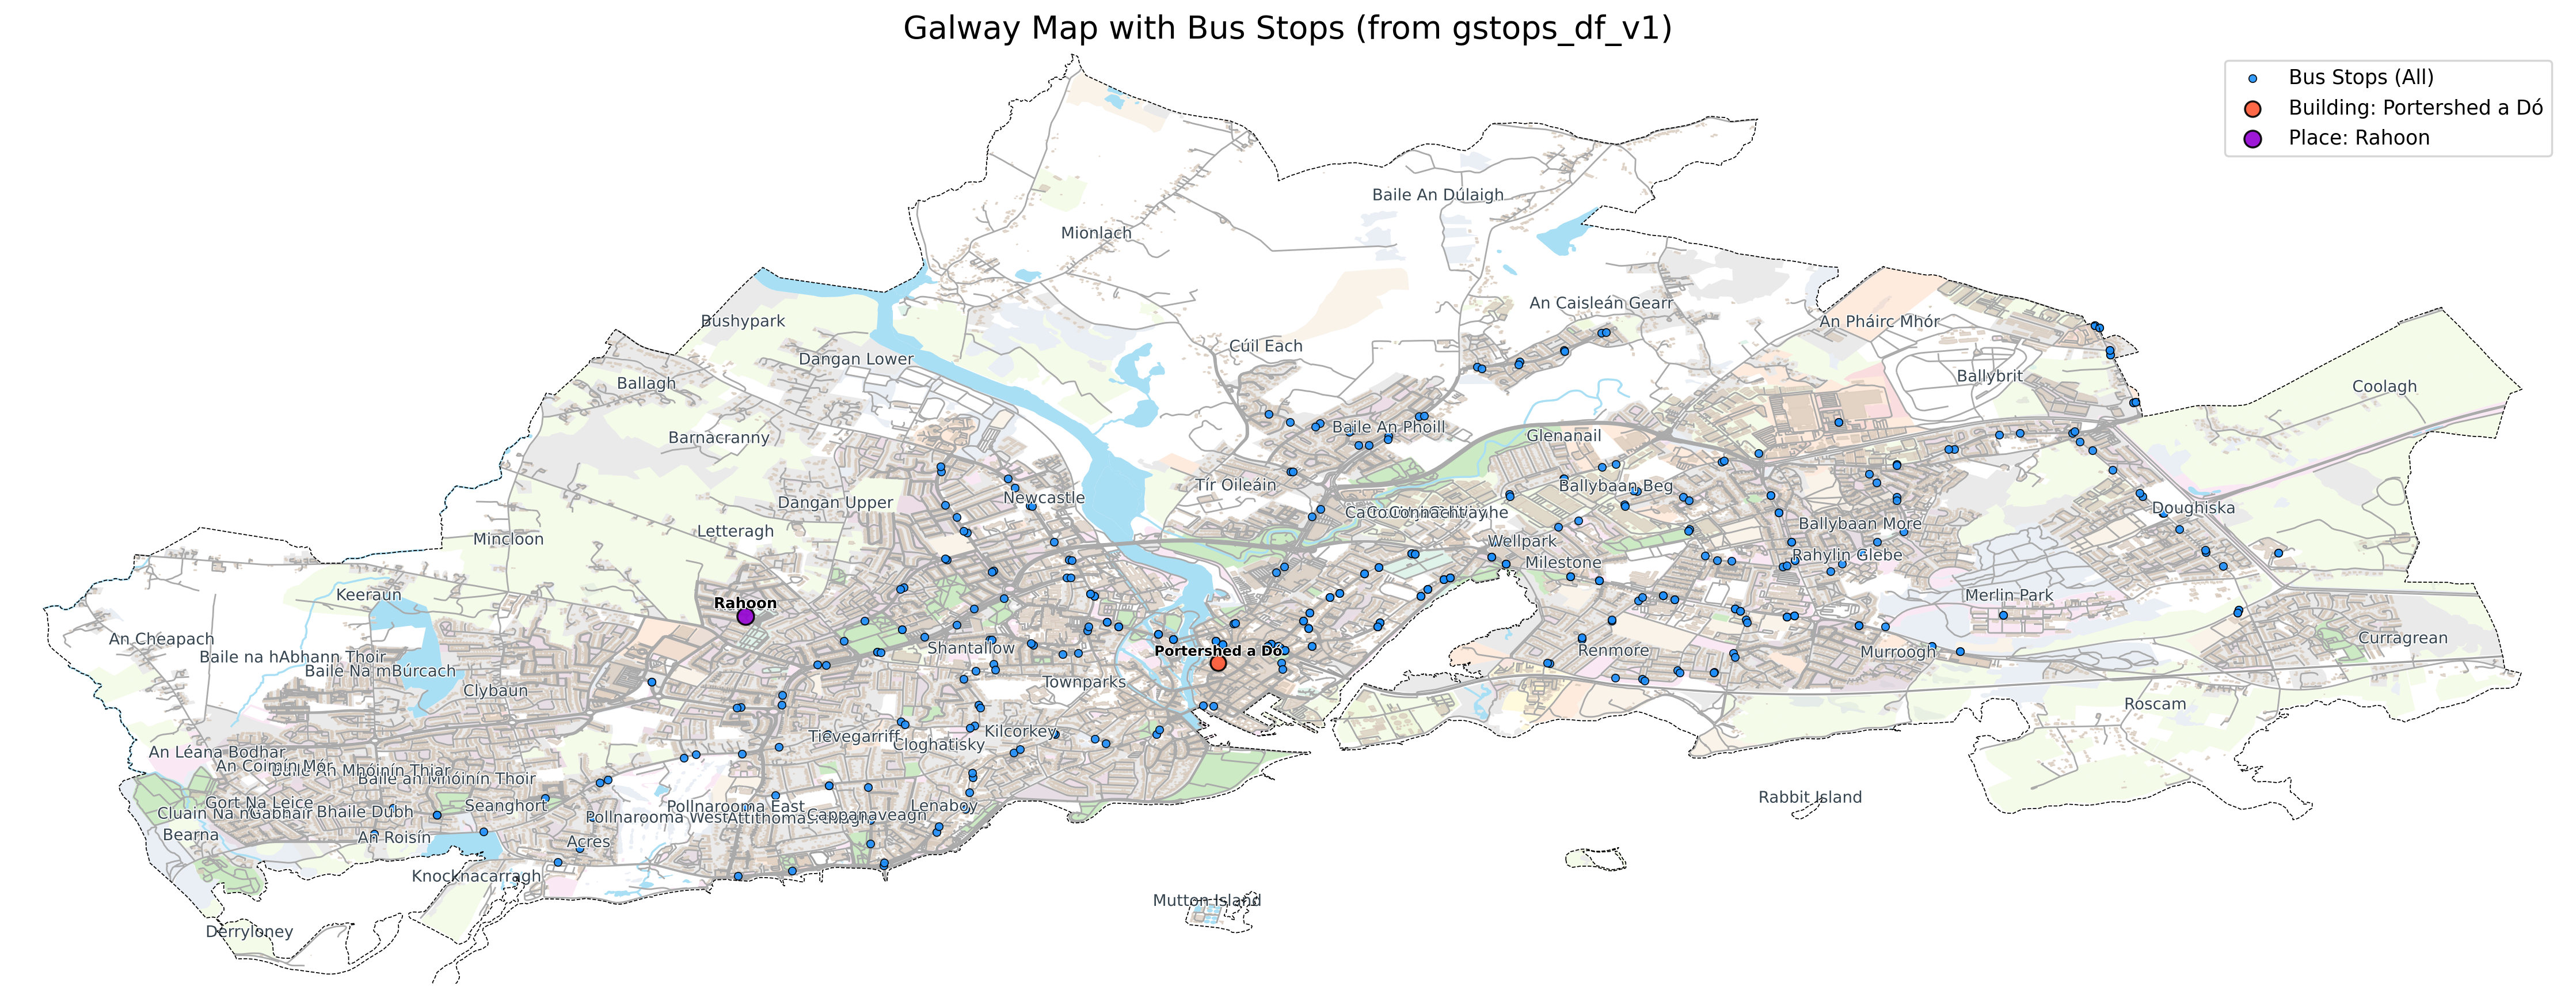

In [12]:
# Configure osmnx settings and logging
ox.config(log_console=True, use_cache=False)
logging.basicConfig(level=logging.INFO)
warnings.filterwarnings("ignore")

# --- Configuration ---
place_name = "Galway, Ireland"
shapefile_base_dir = '/Users/njindal/Documents/aic2025/data/ireland-and-northern-ireland-latest-free.shp' 

shapefile_layers = {
    'roads': 'gis_osm_roads_free_1.shp',
    'water_poly': 'gis_osm_water_a_free_1.shp',
    'railways': 'gis_osm_railways_free_1.shp',
    'waterways': 'gis_osm_waterways_free_1.shp',
    'landuse': 'gis_osm_landuse_a_free_1.shp',
    'buildings': 'gis_osm_buildings_a_free_1.shp',
    'places_poly': 'gis_osm_places_a_free_1.shp'
}

print(f"\n--- Processing Data for: {place_name} ---")
print(f"Using Shapefile directory: {shapefile_base_dir}")

try:
    # --- *** GET GALWAY BOUNDARY *** ---
    print("\nFetching boundary for Galway...")
    boundary_gdf = ox.geocode_to_gdf(place_name).to_crs("EPSG:4326")
    if boundary_gdf.empty:
        raise ValueError(f"Could not geocode '{place_name}'.")
    print(f"Boundary fetched. CRS set to: {boundary_gdf.crs}")



    # --- *** LOAD IRELAND SHAPEFILES & CLIP TO GALWAY BOUNDARY *** ---
    print("\nLoading and clipping Ireland-wide layers to Galway boundary...")
    galway_gdfs = {}
    for layer_name, shp_filename in shapefile_layers.items():
        shp_path = os.path.join(shapefile_base_dir, shp_filename)
        print(f"--- Processing layer: {layer_name} ---")
        if not os.path.exists(shp_path):
            print(f"*** WARNING: Shapefile not found: {shp_path} - Skipping layer '{layer_name}' ***")
            continue
        try:
            ireland_layer_gdf = gpd.read_file(shp_path)
            if ireland_layer_gdf.crs != boundary_gdf.crs:
                ireland_layer_gdf = ireland_layer_gdf.to_crs(boundary_gdf.crs)
            clipped_gdf = gpd.clip(ireland_layer_gdf, boundary_gdf, keep_geom_type=True)
            if not clipped_gdf.empty:
                galway_gdfs[layer_name] = clipped_gdf
            else:
                print(f"Note: No features found for layer '{layer_name}'.")
        except Exception as e:
            print(f"*** ERROR processing layer '{layer_name}': {e} ***")



    # --- *** PREPARE BUS STOP GEODATAFRAME FROM GSTOPS_DF_V1 *** --- 
    print("\nPreparing Galway Bus Stop data from gstops_df_v1...")
    bus_stops_gdf = None
    if 'gstops_df_v1' in locals() and isinstance(gstops_df_v1, pd.DataFrame) and not gstops_df_v1.empty:
        # Ensure 'stop_lat' and 'stop_lon' columns exist
        if 'stop_lat' in gstops_df_v1.columns and 'stop_lon' in gstops_df_v1.columns:
            try:
                # Drop rows with invalid (NaN) coordinates before creating GeoDataFrame
                temp_stops_df = gstops_df_v1.dropna(subset=['stop_lat', 'stop_lon']).copy()
                
                if not temp_stops_df.empty:
                    bus_stops_gdf = gpd.GeoDataFrame(
                        temp_stops_df,
                        geometry=gpd.points_from_xy(temp_stops_df['stop_lon'], temp_stops_df['stop_lat']),
                        crs="EPSG:4326"  
                    )
                    print(f"Created GeoDataFrame 'bus_stops_gdf' with {len(bus_stops_gdf)} stops from gstops_df_v1.")
                    # Reproject if CRS doesn't match the boundary CRS
                    if bus_stops_gdf.crs != boundary_gdf.crs:
                        print(f"Reprojecting bus stops GDF to {boundary_gdf.crs}...");
                        bus_stops_gdf = bus_stops_gdf.to_crs(boundary_gdf.crs)
                        print("Reprojection complete.")
                else:
                    print("Warning: No valid coordinates found in gstops_df_v1 after cleaning.")
            except Exception as e:
                print(f"*** ERROR converting gstops_df_v1 data: {e} ***")
                bus_stops_gdf = None
        else:
            print("Warning: 'stop_lat' or 'stop_lon' columns not found in gstops_df_v1.")
    else:
        print("Warning: 'gstops_df_v1' DataFrame not found or is empty. Please load it first.")


    # --- *** PREPARE BUS ROUTES GEODATAFRAME FROM gvariations_df_v1 *** --- 
    bus_routes_gdf = None # Initialize

    if 'gvariations_df_v1' in locals() and isinstance(gvariations_df_v1, pd.DataFrame) and not gvariations_df_v1.empty and \
    'bus_stops_gdf' in locals() and isinstance(bus_stops_gdf, gpd.GeoDataFrame) and not bus_stops_gdf.empty:

        print("\nEnriching gvariations_df_v1 with first/last stop Point geometries...")
        
        bus_routes_gdf = gvariations_df_v1.copy()
        
        if 'stop_id' in bus_stops_gdf.columns and 'geometry' in bus_stops_gdf.columns:
            
            # --- Handle duplicate stop_ids in bus_stops_gdf to get a unique map ---
            # A single physical stop_id has one location, regardless of how many route directions use it.
            # We keep the first occurrence of each stop_id to get its unique geometry.
            bus_stops_gdf_unique_locations = bus_stops_gdf.drop_duplicates(subset=['stop_id'], keep='first')
            
            # Create the mapping series from this de-duplicated DataFrame
            stop_id_to_point_geometry = bus_stops_gdf_unique_locations.set_index('stop_id')['geometry']
            
        else:
            print("Error: 'stop_id' or 'geometry' column not found in bus_stops_gdf. Cannot map stop Point geometries.")
            stop_id_to_point_geometry = pd.Series(dtype='object') 

        # Map first stop Point geometry
        bus_routes_gdf['first_stop_point'] = bus_routes_gdf['first_stop_id'].map(stop_id_to_point_geometry)
        
        # Map last stop Point geometry
        bus_routes_gdf['last_stop_point'] = bus_routes_gdf['last_stop_id'].map(stop_id_to_point_geometry)
        
        num_first_stops_mapped = bus_routes_gdf['first_stop_point'].notna().sum()
        num_last_stops_mapped = bus_routes_gdf['last_stop_point'].notna().sum()
        
        print(f"Successfully mapped Point geometry for {num_first_stops_mapped} first stops.")
        print(f"Successfully mapped Point geometry for {num_last_stops_mapped} last stops.")

        # Check if any mappings failed (resulting in NaNs)
        if bus_routes_gdf['first_stop_point'].isnull().any() or bus_routes_gdf['last_stop_point'].isnull().any():
            print("Warning: Some first/last stop points could not be mapped (resulting in NaNs).")
            # You could print these rows for inspection:
            # print(bus_routes_gdf[bus_routes_gdf['first_stop_point'].isnull() | bus_routes_gdf['last_stop_point'].isnull()])


        print("\n--- bus_routes_gdf (with Point geometries) ---")
        # Display relevant columns to check the mapping
        display_cols = ['first_stop_id', 'first_stop_point', 'last_stop_id', 'last_stop_point']
        # Add other columns from gvariations_df_v1 if they provide context
        if 'route_id' in bus_routes_gdf.columns: display_cols.insert(0, 'route_id')
        if 'direction_id' in bus_routes_gdf.columns: display_cols.insert(1, 'direction_id')

        print(bus_routes_gdf[display_cols].head())
        print(f"Shape of bus_routes_gdf: {bus_routes_gdf.shape}")

    else:
        print("\nPrerequisite DataFrames ('gvariations_df_v1' or 'bus_stops_gdf') not available or empty. Cannot create bus_routes_gdf.")


      # --- *** CREATE PLACE SUMMARY DATAFRAME *** ---
    print("\nCreating DataFrame for Galway Place Names and Coordinates...")
    galway_places_summary_df = None # Initialize
    if 'places_poly' in galway_gdfs and not galway_gdfs['places_poly'].empty:
        places_data = []
        # Check if the 'name' column exists
        if 'name' not in galway_gdfs['places_poly'].columns:
            print("Warning: 'name' column not found in places_poly layer. Cannot extract place names.")
        else:
            # Iterate through valid polygons with names
            for idx, row in galway_gdfs['places_poly'][galway_gdfs['places_poly']['name'].notna() & galway_gdfs['places_poly'].geometry.is_valid].iterrows():
                place_name_val = row['name']; geometry = row.geometry; rep_point = None
                # Get representative point (or centroid as fallback)
                if hasattr(geometry, 'representative_point'):
                    try: rep_point = geometry.representative_point()
                    except Exception: rep_point = geometry.centroid # Fallback if representative_point fails
                else: rep_point = geometry.centroid # Fallback if method doesn't exist
                # Append if point is valid
                if rep_point and rep_point.is_valid:
                    places_data.append({'place_name': place_name_val,'latitude': rep_point.y,'longitude': rep_point.x})
            # Create DataFrame if data was extracted
            if places_data:
                galway_places_summary_df = pd.DataFrame(places_data)
                print(f"Created DataFrame 'galway_places_summary_df' with {len(galway_places_summary_df)} places.")
                print(galway_places_summary_df.head())
            else: print("No valid places with names found to create summary DataFrame.")
    else: print("Clipped 'places_poly' GeoDataFrame not found or is empty.")

    galway_places_summary_df1 = None # Initialize

    if 'galway_places_summary_df' in locals() and isinstance(galway_places_summary_df, pd.DataFrame) and not galway_places_summary_df.empty:
        galway_places_summary_df1 = galway_places_summary_df.copy()
        if 'place_name' in galway_places_summary_df1.columns:
            galway_places_summary_df1 = galway_places_summary_df1.sort_values('place_name').reset_index(drop=True)
        else:
            print("Warning: 'place_name' column not found for sorting. Index will be based on current order.")

        # Create custom indices starting with 'P'
        place_indices = [f'P{i+1}' for i in range(len(galway_places_summary_df1))]
        galway_places_summary_df1.index = place_indices

        print("\nCreated DataFrame 'galway_places_summary_df1' with custom 'P' indices:")
        print(f"Number of places: {len(galway_places_summary_df1)}")
        print("\nFirst few rows of 'galway_places_summary_df1':")
        print(galway_places_summary_df1.head())
    else:
        print("Cannot create 'galway_places_summary_df1' as 'galway_places_summary_df' is not available or is empty.")
    # --- *** END PLACES SECTION *** ---



# --- *** CHECK RAHOON PLACE ID FOR PLOTTING *** ---
    rahoon_place_id = None # To store the 'P' index if Rahoon is found
    if 'galway_places_summary_df1' in locals() and isinstance(galway_places_summary_df1, pd.DataFrame) and not galway_places_summary_df1.empty:
        if 'place_name' in galway_places_summary_df1.columns:
            # Search for 'Rahoon' in the 'place_name' column 
            rahoon_search_results = galway_places_summary_df1[galway_places_summary_df1['place_name'].str.contains('Rahoon', case=False, na=False)]

            if not rahoon_search_results.empty:
                print(f"\n--- Found 'Rahoon' in galway_places_summary_df1 ---")
                rahoon_place_data = rahoon_search_results.iloc[0]
                rahoon_place_id = rahoon_place_data.name 
                print(f"Place Name: {rahoon_place_data['place_name']}")
                print(f"Index (ID): {rahoon_place_id}")
                print(f"Latitude: {rahoon_place_data['latitude']}")
                print(f"Longitude: {rahoon_place_data['longitude']}")
            else:
                print("\nPlace name containing 'Rahoon' not found in galway_places_summary_df1.")
        else:
            print("\n'place_name' column not found in galway_places_summary_df1.")
    else:
        print("\nDataFrame 'galway_places_summary_df1' not available for searching 'Rahoon'.")




# --- *** CREATE BUILDINGS SUMMARY DATAFRAME *** ---
    print("\nCreating DataFrame for Galway Buildings with Type and Coordinates...")
    galway_buildings_summary_df = None # Initialize
    if 'buildings' in galway_gdfs and not galway_gdfs['buildings'].empty:
        buildings_data = []

        # Check what columns are available in the buildings layer
        print(f"Available columns in buildings layer: {galway_gdfs['buildings'].columns.tolist()}")

        # Extract building info - name, osm_id, and type (typically in fclass or type column)
        for idx, row in galway_gdfs['buildings'][galway_gdfs['buildings'].geometry.is_valid].iterrows():
            osm_id = row.get('osm_id', None)
            name = row.get('name', None)
            building_type = None
            for type_col in ['fclass', 'type', 'building']:
                if type_col in row and row[type_col] is not None:
                    building_type = row[type_col]; break
            try:
                centroid = row.geometry.centroid
                if centroid and centroid.is_valid:
                    buildings_data.append({
                        'building_name': name, 'osm_id': osm_id, 'building_type': building_type,
                        'latitude': centroid.y, 'longitude': centroid.x
                    })
            except Exception as e: print(f"Error calculating centroid for building {osm_id}: {e}")

        if buildings_data:
            galway_buildings_summary_df = pd.DataFrame(buildings_data)
            print(f"Created DataFrame 'galway_buildings_summary_df' with {len(galway_buildings_summary_df)} buildings.")
            print(galway_buildings_summary_df.head())
        else: print("No valid building data found to create summary DataFrame.")
    else: print("Clipped 'buildings' GeoDataFrame not found or is empty.")

    # --- *** REFINE BUILDING SUMMARY DATAFRAME *** ---
    galway_buildings_summary_df1 = None # Initialize
    if galway_buildings_summary_df is not None:
        galway_buildings_summary_df1 = galway_buildings_summary_df[galway_buildings_summary_df['building_name'].notnull()].copy()
        galway_buildings_summary_df1 = galway_buildings_summary_df1.sort_values('building_name')
        building_indices = [f'B{i+1}' for i in range(len(galway_buildings_summary_df1))]
        galway_buildings_summary_df1.index = building_indices
        print("\nCreated filtered DataFrame 'galway_buildings_summary_df1' with named buildings:")
        print(f"Number of named buildings: {len(galway_buildings_summary_df1)}")
        print("\nFirst few rows of filtered DataFrame:")
        print(galway_buildings_summary_df1.head())
    else: print("Cannot create filtered DataFrame as galway_buildings_summary_df is None")

    # --- *** END BUILDINGS SECTION *** ---


    # --- *** PLOTTING CLIPPED GALWAY DATA *** ---
    print("\nPlotting clipped Galway map layers...")
    fig, ax = plt.subplots(figsize=(18, 18), facecolor='white', dpi=250)

    # Define base colors
    color_water = '#a8dff5'; color_land = '#f2f4f6'; color_parks = '#cceac4'
    color_buildings_osm = '#d8cabc' # Renamed to avoid conflict
    color_roads = '#aaaaaa'; color_rail = '#a0a0a0';color_place_text = '#36454F'  # Charcoal for place labels
    
    # Define bus stop color
    color_bus_stops_blue = '#1E90FF' # Dodger blue for all bus stops

    # Set background
    ax.set_facecolor(color_land)

    # Define approximate z-orders
    zorder_landuse=1; zorder_water_poly=2; zorder_parks=3; zorder_buildings_layer=4 # General buildings layer
    zorder_waterways=5; zorder_railways=6; zorder_roads=7;
    zorder_bus_stops_plot = 8    # Z-order for general bus stops
    zorder_place_text = 9        # Z-order for general place name labels

    # Z-orders for the specific B422 building highlight - Portershed
    zorder_building_b422_point = 10  
    zorder_building_b422_text = 11  

    # Z-orders for the specific 'Rahoon' place highlight
    zorder_rahoon_place_point = 10 
    zorder_rahoon_place_text = 11  


    zorder_boundary = 12   # Boundary should be having highest zorder to frame everything
    

    # Plot base layers
    if 'landuse' in galway_gdfs: galway_gdfs['landuse'].plot(ax=ax, column='fclass', categorical=True, cmap='Pastel2', alpha=0.4, zorder=zorder_landuse)
    if 'water_poly' in galway_gdfs: galway_gdfs['water_poly'].plot(ax=ax, color=color_water, edgecolor='none', zorder=zorder_water_poly)
    if 'landuse' in galway_gdfs and 'fclass' in galway_gdfs['landuse'].columns:
        parks_gdf = galway_gdfs['landuse'][galway_gdfs['landuse']['fclass'] == 'park']
        if not parks_gdf.empty: parks_gdf.plot(ax=ax, color=color_parks, edgecolor='none', zorder=zorder_parks)
    if 'buildings' in galway_gdfs: galway_gdfs['buildings'].plot(ax=ax, facecolor=color_buildings_osm, alpha=0.7, lw=0.5, edgecolor=color_buildings_osm, zorder=zorder_buildings_layer)
    if 'waterways' in galway_gdfs: galway_gdfs['waterways'].plot(ax=ax, color=color_water, linewidth=1.0, zorder=zorder_waterways)
    if 'railways' in galway_gdfs:
        galway_gdfs['railways'].plot(ax=ax, color='#ffffff', linewidth=2.0, linestyle='-', zorder=zorder_railways)
        galway_gdfs['railways'].plot(ax=ax, color=color_rail, linewidth=1.0, linestyle='-', zorder=zorder_railways + 0.1)
    if 'roads' in galway_gdfs: galway_gdfs['roads'].plot(ax=ax, color=color_roads, linewidth=0.8, zorder=zorder_roads)

    # --- Plot ALL Bus Stops from gstops_df_v1 as BLUE DOTS ---
    if bus_stops_gdf is not None and not bus_stops_gdf.empty:
        bus_stops_gdf.plot(
            ax=ax,
            color=color_bus_stops_blue, # Use the defined blue color
            marker='o',
            markersize=15,             
            edgecolor='black',        
            linewidth=0.5,
            alpha=0.9,
            zorder=zorder_bus_stops_plot, # Ensure they are on top of most layers
            label='Bus Stops (All)'
        )
        print(f"Plotted {len(bus_stops_gdf)} bus stops from gstops_df_v1 as blue dots.")
    else:
        print("No bus stops from gstops_df_v1 to plot.")


    # --- Plot Place Names (No Circles) ---
    if galway_places_summary_df is not None and not galway_places_summary_df.empty:
        print(f"Plotting {len(galway_places_summary_df)} place names...")
        plotted_place_names_map = set()
        for idx, row in galway_places_summary_df.iterrows():
            label = row['place_name']; point_x = row['longitude']; point_y = row['latitude']
            if label not in plotted_place_names_map:
                ax.text(point_x, point_y + 0.0002, label, fontsize=8, color=color_place_text,
                        ha='center', va='bottom', zorder=zorder_place_text, fontweight='normal',
                        path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground='w')])
                plotted_place_names_map.add(label)
        print("Place names plotted.")

    # --- *** PLOT B422 BUILDING - PORTERSHED *** ---
    if 'galway_buildings_summary_df1' in locals() and galway_buildings_summary_df1 is not None and not galway_buildings_summary_df1.empty:
        building_point_color = '#FF5733' # Orange
        building_text_color = '#000000'  # Black
        plotted_b422 = False
        # Ensure B422 exists in your dataframe's index
        if 'B422' in galway_buildings_summary_df1.index:
            row = galway_buildings_summary_df1.loc['B422']
            point_x = row['longitude']
            point_y = row['latitude']
            building_name = row['building_name']
            
            # Plot orange circle for B422
            plt.scatter(point_x, point_y, s=60, color=building_point_color, edgecolor='black', # Increased size (s=60)
                        linewidth=1, alpha=0.9, zorder=zorder_building_b422_point, label=f'Building: {building_name}')
            
            # Plot name label for B422
            ax.text(point_x, point_y + 0.0003, building_name, fontsize=7, color=building_text_color, 
                    ha='center', va='bottom', zorder=zorder_building_b422_text, fontweight='bold',
                    path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground='white')])
            plotted_b422 = True
            print(f"Plotted orange circle and name label for building B422 ('{building_name}').")
        else:
            print("Building B422 not found in the DataFrame 'galway_buildings_summary_df1'.")
    else:
        print("DataFrame 'galway_buildings_summary_df1' not available for plotting B422.")
    # --- *** END OF B422 PLOTTING CODE *** ---   



    # --- *** PLOT SPECIFIC PLACE 'RAHOON' *** ---
    if 'rahoon_place_id' in locals() and rahoon_place_id is not None and \
       'galway_places_summary_df1' in locals() and galway_places_summary_df1 is not None and \
       not galway_places_summary_df1.empty:

        if rahoon_place_id in galway_places_summary_df1.index:
            place_row = galway_places_summary_df1.loc[rahoon_place_id]
            point_x = place_row['longitude']
            point_y = place_row['latitude']
            place_name_label = place_row['place_name'] 

            place_point_color = '#9400D3' # Dark Violet 
            place_text_color = '#000000'   # Black

            # Plot distinct circle for 'Rahoon'
            plt.scatter(point_x, point_y, s=70, color=place_point_color, edgecolor='black', 
                        linewidth=1, alpha=0.9, zorder=zorder_rahoon_place_point, label=f'Place: {place_name_label}')

            # Plot name label for 'Rahoon'
            ax.text(point_x, point_y + 0.00035, place_name_label, fontsize=7.5, color=place_text_color,
                    ha='center', va='bottom', zorder=zorder_rahoon_place_text, fontweight='bold',
                    path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground='white')])
            print(f"Plotted distinct circle and name label for place: '{place_name_label}' (ID: {rahoon_place_id}).")
        else:
            print(f"Place with ID '{rahoon_place_id}' (expected to be Rahoon) not found in galway_places_summary_df1.index for plotting.")
    else:
        print("Rahoon was not identified or 'galway_places_summary_df1' is not available for plotting specific place.")
    # --- *** END OF 'RAHOON' PLOTTING CODE *** ---


    # Plot boundary outline for context last
    boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, linestyle='--', zorder=zorder_boundary)

    # --- Set Map Bounds ---
    if 'roads' in galway_gdfs and not galway_gdfs['roads'].empty:
        minx, miny, maxx, maxy = galway_gdfs['roads'].total_bounds
    else:
        minx, miny, maxx, maxy = boundary_gdf.total_bounds
    margin_factor = 0.02
    margin_x = (maxx - minx) * margin_factor
    margin_y = (maxy - miny) * margin_factor
    ax.set_xlim(minx - margin_x, maxx + margin_x)
    ax.set_ylim(miny - margin_y, maxy + margin_y)
    ax.set_aspect('equal', adjustable='box')

    # Final plot adjustments
    ax.set_title(f"Galway Map with Bus Stops (from gstops_df_v1)", color='black', fontsize=16)
    plt.legend(loc='upper right') # add a legend
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    # print("\nPlot displayed.")

except FileNotFoundError as e:
    print(f"\n--- File Error ---\n{e}\nPlease ensure file paths are correct.")
except ImportError as e:
    print(f"\n--- Import Error Occurred ---\nError: {e}\nPlease ensure required libraries are installed.")
except ValueError as e:
    print(f"\n--- Value Error ---\n{e}")
except Exception as e:
    print(f"\n--- An Unexpected Error Occurred ---\nError: {e}")
    import traceback
    traceback.print_exc()

### 6. Stop and Route Name Standardization

In [13]:
# --- Abbreviation Expansion and Parentheses Removal Function ---
def expand_abbr_and_remove_paren(text_to_process):
    if pd.isna(text_to_process):
        return text_to_process

    current_text = str(text_to_process) 
    
    abbreviations = {
        r'\brd\b': 'road',
        r'\bst\b': 'street',
        r'\blwr\b': 'lower',
        r'\bav\b': 'avenue',
        r'\bave\b': 'avenue',
        r'\bopp\b': 'opposite',
        r'\bind est\b': 'industrial estate',
    }
    
    expanded_text = current_text
    for abbr, expansion in abbreviations.items():
        expanded_text = re.sub(abbr, expansion, expanded_text)
    
    text_after_paren_open_removed = re.sub(r'\s*\(\s*', ' ', expanded_text) 
    text_after_paren_close_removed = re.sub(r'\s*\)\s*', ' ', text_after_paren_open_removed)
    
    # Consolidate multiple spaces into one
    final_text = re.sub(r'\s+', ' ', text_after_paren_close_removed).strip()
        
    return final_text

# --- Prepare bus_stops_gdf ---
if 'bus_stops_gdf' in locals() and isinstance(bus_stops_gdf, pd.DataFrame) and not bus_stops_gdf.empty:
    if 'stop_name' in bus_stops_gdf.columns:    
        bus_stops_gdf['stop_name_norm_explicit'] = bus_stops_gdf['stop_name'].astype(str).str.lower().str.strip()
        bus_stops_gdf['stop_name_norm_expanded'] = bus_stops_gdf['stop_name_norm_explicit'].apply(expand_abbr_and_remove_paren)
        print("bus_stops_gdf prepared.")
    else:
        print("Error: 'stop_name' column not found in bus_stops_gdf.")
else:
    print("Error: bus_stops_gdf is not defined or is empty.")

# --- Prepare bus_timetables ---
if 'bus_timetables' in locals() and isinstance(bus_timetables, pd.DataFrame) and not bus_timetables.empty:
    if 'ROUTE' in bus_timetables.columns: 
        bus_timetables['ROUTE_norm_explicit'] = bus_timetables['ROUTE'].astype(str).str.lower().str.strip()
        bus_timetables['ROUTE_norm_expanded'] = bus_timetables['ROUTE_norm_explicit'].apply(expand_abbr_and_remove_paren)
        
        print("bus_timetables prepared.")
    else:
        print("Error: 'ROUTE' column not found in bus_timetables.")
else:
    print("\nError: bus_timetables DataFrame is not defined or is empty.")


bus_stops_gdf prepared.
bus_timetables prepared.


### 7. Bus Stop Matching and Route Mapping

In [14]:
# --- MATCHING FUNCTION (Exact -> Fuzzy -> Token Overlap) ---
def find_stop_id_expanded_match(route_norm_expanded_to_match, stops_df):
    if pd.isna(route_norm_expanded_to_match):
        return None, "Input ROUTE_norm_expanded is NaN", None, np.nan, np.nan

    if not isinstance(stops_df, pd.DataFrame) or stops_df.empty:
        return None, "stops_df (bus_stops_gdf) is invalid or empty", None, np.nan, np.nan

    required_cols = ['stop_name_norm_expanded', 'stop_id', 'stop_name']
    if not all(col in stops_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in stops_df.columns]
        return None, f"Missing required columns in stops_df: {missing}", None, np.nan, np.nan

    matched_stop_id = None
    match_method = "No Initial Match" # Default if no stages match
    matched_original_stop_name_in_gdf = None
    fuzz_ratio_score = np.nan
    fuzz_wratio_score = np.nan

    # --- Stage 1: Exact match ---
    exact_match_gdf = stops_df[stops_df['stop_name_norm_expanded'] == route_norm_expanded_to_match]
    if not exact_match_gdf.empty:
        matched_stop_id = exact_match_gdf.iloc[0]['stop_id']
        matched_original_stop_name_in_gdf = exact_match_gdf.iloc[0]['stop_name']
        match_method = "Exact Expanded Name" + (" (Multiple GDF matches, took first)" if len(exact_match_gdf) > 1 else "")
        fuzz_ratio_score, fuzz_wratio_score = 100, 100
        return matched_stop_id, match_method, matched_original_stop_name_in_gdf, fuzz_ratio_score, fuzz_wratio_score

    # --- Stage 2: Fuzzy match ---
    choices = stops_df['stop_name_norm_expanded'].dropna().tolist()
    if choices:
        best_match_wratio_tuple = process.extractOne(route_norm_expanded_to_match, choices, scorer=fuzz.WRatio, score_cutoff=88)
        if best_match_wratio_tuple:
            best_matched_expanded_name_in_gdf = best_match_wratio_tuple[0]
            fuzz_wratio_score = best_match_wratio_tuple[1]
            fuzz_ratio_score = fuzz.ratio(route_norm_expanded_to_match, best_matched_expanded_name_in_gdf)
            gdf_row_for_best_match = stops_df[stops_df['stop_name_norm_expanded'] == best_matched_expanded_name_in_gdf]
            if not gdf_row_for_best_match.empty:
                matched_stop_id = gdf_row_for_best_match.iloc[0]['stop_id']
                matched_original_stop_name_in_gdf = gdf_row_for_best_match.iloc[0]['stop_name']
                match_method = f"Fuzzy Expanded Name (WRatio: {fuzz_wratio_score:.0f})"
                return matched_stop_id, match_method, matched_original_stop_name_in_gdf, fuzz_ratio_score, fuzz_wratio_score
            else: # Should be rare
                match_method = "Fuzzy Match Found but GDF Row Missing"
                return None, match_method, None, fuzz_ratio_score, fuzz_wratio_score
    
    # --- Stage 3: Token-based Overlap Match (if no exact or fuzzy match) ---
    if matched_stop_id is None and isinstance(route_norm_expanded_to_match, str) and len(route_norm_expanded_to_match.strip()) > 0:
        route_tokens = set(route_norm_expanded_to_match.split())
        if not route_tokens:
             return None, "No Final Match (Empty Route Tokens)", None, np.nan, np.nan

        best_overlap_score = 0
        candidate_stop_id = None
        candidate_original_name = None
        best_gdf_name_for_token_match = None # For tie-breaking

        # Minimum common tokens required for this type of match
        min_required_common_tokens = 1 

        for index, row in stops_df.iterrows():
            gdf_stop_name_expanded = row['stop_name_norm_expanded']
            if pd.isna(gdf_stop_name_expanded):
                continue
            
            gdf_tokens = set(gdf_stop_name_expanded.split())
            if not gdf_tokens:
                continue
                
            common_tokens = route_tokens.intersection(gdf_tokens)
            current_overlap_score = len(common_tokens)
            
            if current_overlap_score >= min_required_common_tokens:
                if current_overlap_score > best_overlap_score:
                    best_overlap_score = current_overlap_score
                    candidate_stop_id = row['stop_id']
                    candidate_original_name = row['stop_name']
                    best_gdf_name_for_token_match = gdf_stop_name_expanded
                elif current_overlap_score == best_overlap_score:
                    # Tie-breaking: prefer shorter GDF name if overlap score is the same
                    if candidate_original_name is None or (best_gdf_name_for_token_match and len(gdf_stop_name_expanded) < len(best_gdf_name_for_token_match)):
                        candidate_stop_id = row['stop_id']
                        candidate_original_name = row['stop_name']
                        best_gdf_name_for_token_match = gdf_stop_name_expanded
                            
        if candidate_stop_id is not None:
            matched_stop_id = candidate_stop_id
            matched_original_stop_name_in_gdf = candidate_original_name
            match_method = f"Token Overlap Match (Score: {best_overlap_score})"
            # Fuzzy scores are not applicable here, remain np.nan
            return matched_stop_id, match_method, matched_original_stop_name_in_gdf, np.nan, np.nan

    # If no match from any stage
    final_match_method = "No Final Match" if match_method == "No Initial Match" else match_method
    return None, final_match_method, None, np.nan, np.nan


# --- APPLYING THE MATCHING TO bus_timetables ---
# (Ensure bus_timetables and bus_stops_gdf are prepared as before)

if ('bus_timetables' in locals() and isinstance(bus_timetables, pd.DataFrame) and not bus_timetables.empty and
    'ROUTE_norm_expanded' in bus_timetables.columns and
    'bus_stops_gdf' in locals() and isinstance(bus_stops_gdf, pd.DataFrame) and not bus_stops_gdf.empty and
    'stop_name_norm_expanded' in bus_stops_gdf.columns and 'stop_name' in bus_stops_gdf.columns and 'stop_id' in bus_stops_gdf.columns):

    print("\nMapping ROUTE_norm_expanded to stop_id (Exact -> Fuzzy -> Token Overlap)...")
    
    match_results_tuples = bus_timetables['ROUTE_norm_expanded'].apply(
        lambda x: find_stop_id_expanded_match(x, bus_stops_gdf.copy()) # Pass a copy of bus_stops_gdf
    )
    
    bus_timetables['stop_id_mapped'] = [res[0] for res in match_results_tuples]
    bus_timetables['match_method'] = [res[1] for res in match_results_tuples]
    bus_timetables['matched_stop_name_in_gdf'] = [res[2] for res in match_results_tuples]
    bus_timetables['fuzz_ratio_score'] = [res[3] for res in match_results_tuples] 
    bus_timetables['fuzz_wratio_score'] = [res[4] for res in match_results_tuples]

    print("Mapping complete.")
    print("\n--- bus_timetables with mapped stop_id (Exact -> Fuzzy -> Token Overlap) ---")
    display_cols = ['ROUTE', 'ROUTE_norm_expanded', 'stop_id_mapped', 'match_method', 'matched_stop_name_in_gdf', 'fuzz_ratio_score', 'fuzz_wratio_score']
    if 'route_id' in bus_timetables.columns: # Add route_id if it exists
        if 'ROUTE_norm_expanded' in display_cols and 'route_id' not in display_cols:
             display_cols.insert(display_cols.index('ROUTE_norm_expanded') + 1, 'route_id')
        elif 'route_id' not in display_cols:
            display_cols.append('route_id')
            
    final_display_cols = [col for col in display_cols if col in bus_timetables.columns]
    
    # print("Head of mapped bus_timetables:")
    # display(bus_timetables[final_display_cols].head(20)) # Assuming display is available
    
    print("\nMatch Method Distribution:")
    # print(bus_timetables['match_method'].value_counts(dropna=False))
    
    unmapped_count = bus_timetables['stop_id_mapped'].isna().sum()
    print(f"\nNumber of ROUTEs not mapped to a stop_id: {unmapped_count} out of {len(bus_timetables)}")
    
    if unmapped_count > 0:
        print("Sample of unmapped ROUTEs:")
        unmapped_sample_cols = ['ROUTE', 'ROUTE_norm_expanded', 'match_method']
        if 'route_id' in bus_timetables.columns: unmapped_sample_cols.append('route_id')
        unmapped_sample_cols = [col for col in unmapped_sample_cols if col in bus_timetables.columns]
        if unmapped_sample_cols:
            display(bus_timetables[bus_timetables['stop_id_mapped'].isna()][unmapped_sample_cols].head(10))
            
    print("\nReview Token Overlap Matches:")
    if 'match_method' in bus_timetables.columns:
        token_overlap_review = bus_timetables[bus_timetables['match_method'].str.contains("Token Overlap", na=False)][final_display_cols]
        if not token_overlap_review.empty:
            display(token_overlap_review.head(10))
        else:
            print("No Token Overlap matches found to review.")
else:
    print("\nCannot perform mapping. Prerequisites not met (check DataFrames and required columns).")


# Replace empty strings in 'stop_id_mapped' with pd.NA (or np.nan)
bus_timetables['stop_id_mapped'] = bus_timetables['stop_id_mapped'].replace('', pd.NA)

# Drop rows where 'stop_id_mapped' is NA
bus_timetables = bus_timetables.dropna(subset=['stop_id_mapped'])




Mapping ROUTE_norm_expanded to stop_id (Exact -> Fuzzy -> Token Overlap)...
Mapping complete.

--- bus_timetables with mapped stop_id (Exact -> Fuzzy -> Token Overlap) ---

Match Method Distribution:

Number of ROUTEs not mapped to a stop_id: 3 out of 180
Sample of unmapped ROUTEs:


ROUTE  \
158  Br Brendain Ui Either (Go Bus Office)   
178                              Medtronic   
179                              Celestica   

                     ROUTE_norm_expanded    match_method  route_id  
158  br brendain ui either go bus office  No Final Match       409  
178                            medtronic  No Final Match       409  
179                            celestica  No Final Match       409


Review Token Overlap Matches:


ROUTE  \
11        Ballybane Rd (John Paul Centre)   
13         Ballybane Rd (Shopping Centre)   
15              McDonagh Ave (Old Mervue)   
31     Upper Salthill Rd (Canton Kitchen)   
32  Upper Salthill Rd (Opp Western House)   
36           Dr Mannix Rd (Rockbarton Rd)   
46   Taylors Hill Rd (Threadneedle Junct)   
48       Taylors Hill Rd (Highfield Park)   
49         Taylors Hill Rd (Opp St Annes)   
56     Newcastle Rd (University Hospital)   

                           ROUTE_norm_expanded  route_id stop_id_mapped  \
11             ballybane road john paul centre       401   8460B5235601   
13              ballybane road shopping centre       401   8460B5235601   
15                  mcdonagh avenue old mervue       401   8460B5227601   
31          upper salthill road canton kitchen       401   8460B5220701   
32  upper salthill road opposite western house       401   8460B5220701   
36              dr mannix road rockbarton road       401   8460B5223701   
46        taylors hill road threadneedle junct       402   8460B5224301   
48            taylors hill road highfield park       402   8460B5224301   
49     taylors hill road opposite street annes       402   8460B5258501   
56          newcastle road university hospital       402   8460B5225501   

                      match_method matched_stop_name_in_gdf  fuzz_ratio_score  \
11  Token Overlap Match (Score: 2)         Ballybane Centre               NaN   
13  Token Overlap Match (Score: 2)         Ballybane Centre               NaN   
15  Token Overlap Match (Score: 1)             Rowan Avenue               NaN   
31  Token Overlap Match (Score: 2)      Salthill Road Lower               NaN   
32  Token Overlap Match (Score: 2)      Salthill Road Lower               NaN   
36  Token Overlap Match (Score: 1)               Barna Road               NaN   
46  Token Overlap Match (Score: 2)       Taylor's Hill Road               NaN   
48  Token Overlap Match (Score: 2)       Taylor's Hill Road               NaN   
49  Token Overlap Match (Score: 2)            St James Road               NaN   
56  Token Overlap Match (Score: 2)     Lower Newcastle Road               NaN   

    fuzz_wratio_score  
11                NaN  
13                NaN  
15                NaN  
31                NaN  
32                NaN  
36                NaN  
46                NaN  
48                NaN  
49                NaN  
56                NaN

In [18]:
print('galway_places_summary_df1')
display(galway_places_summary_df1.head(2))
print('galway_buildings_summary_df1')
display(galway_buildings_summary_df1.head(2))
print('bus_stops_gdf')
display(bus_stops_gdf.head(2))
print('bus_timetables')
display(bus_timetables.head(2))
print('bus_routes_gdf')
display(bus_routes_gdf.head(2))

galway_places_summary_df1


place_name   latitude  longitude
P1              Acres  53.259219  -9.101356
P2  An Caisleán Gearr  53.300020  -9.024591

galway_buildings_summary_df1


building_name     osm_id building_type   latitude  longitude
B1  7th Day Adventist Church  160662154      building  53.274181  -8.998755
B2                       AIB  101455935      building  53.285489  -9.034300

bus_stops_gdf


stop_id        stop_name   stop_lat  stop_lon  direction  route_id  \
BS1  8460B5220101     Spanish Arch  53.270394  -9.05478          0       401   
BS2  8460B5220201  Fr Griffin Road  53.268232  -9.05834          0       401   

                      geometry stop_name_norm_explicit stop_name_norm_expanded  
BS1  POINT (-9.05478 53.27039)            spanish arch            spanish arch  
BS2  POINT (-9.05834 53.26823)         fr griffin road         fr griffin road

bus_timetables


route_id                     ROUTE  stop_order_on_route  \
0       401  Parkmore Rd (Roundabout)                    0   
1       401              Ballybrit RC                    1   

        ROUTE_norm_explicit       ROUTE_norm_expanded stop_id_mapped  \
0  parkmore rd (roundabout)  parkmore road roundabout    8460B555431   
1              ballybrit rc              ballybrit rc   8460B5234401   

                                             match_method  \
0                        Fuzzy Expanded Name (WRatio: 90)   
1  Exact Expanded Name (Multiple GDF matches, took first)   

  matched_stop_name_in_gdf  fuzz_ratio_score  fuzz_wratio_score  
0            Parkmore Road              70.0               90.0  
1             Ballybrit RC             100.0              100.0

bus_routes_gdf


route_long_name  g_trip_headsign  route_id  route_short_name  \
BR1  Eyre Square - Salthill  Dr. Mannix Road       401               401   
BR2  Eyre Square - Salthill  Dr. Mannix Road       401               401   

     direction_id variation_route_id first_stop_id  last_stop_id  \
BR1             0         4023_65528  8460B5234401  8460B5221101   
BR2             0         4023_65528  8460B5234401   8460B522301   

    first_stop_name       last_stop_name  num_stops  \
BR1    Ballybrit RC        Salthill Park         37   
BR2    Ballybrit RC  Scoil Éinde Boys NS         37   

              first_stop_point            last_stop_point  
BR1  POINT (-8.98609 53.29733)  POINT (-9.07902 53.25830)  
BR2  POINT (-8.98609 53.29733)  POINT (-9.08316 53.26435)

In [ ]:


# --- Helper Function for Haversine Distance ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    try:
        lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(radians, [float(lat1), float(lon1), float(lat2), float(lon2)])
    except (ValueError, TypeError):
        # print(f"Error converting coordinates to float: lat1={lat1}, lon1={lon1}, lat2={lat2}, lon2={lon2}")
        return float('inf')
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c * 1000


# --- 1. Initialize Graph ---
G = nx.DiGraph()
print("Graph initialized.")

# --- Step 1a: Add Place Nodes (General POIs) ---
# (Code remains the same)
print("\nAdding place nodes (general POIs)...")
for index, row in galway_places_summary_df1.iterrows():
    place_node_id = row['place_name']
    G.add_node(place_node_id, type='place', name=row['place_name'], latitude=row['latitude'], longitude=row['longitude'])
print(f"Nodes after general places: {G.number_of_nodes()}")

# --- Step 1b: Add Building Nodes (Specific Building POIs) ---
# (Code remains the same)
print("\nAdding building nodes...")
for index, row in galway_buildings_summary_df1.iterrows():
    building_node_id = row['building_name']
    G.add_node(building_node_id, type='building', name=row['building_name'], osm_id=row.get('osm_id'),
               building_type=row.get('building_type'), latitude=row['latitude'], longitude=row['longitude'])
print(f"Nodes after adding buildings: {G.number_of_nodes()}")

# --- Step 1c: Add Unique Bus Stop Nodes ---
# (Code remains the same)
print("\nAdding unique bus stop nodes...")
added_stop_ids = set()
for index, row in bus_stops_gdf.iterrows():
    stop_id = row['stop_id']
    if stop_id not in added_stop_ids:
        G.add_node(stop_id, type='bus_stop', name=row['stop_name'], latitude=row['stop_lat'], longitude=row['stop_lon'],
                   direction=row.get('direction'), original_route_id=row.get('route_id'), geometry=row.get('geometry'),
                   norm_explicit=row.get('stop_name_norm_explicit'), norm_expanded=row.get('stop_name_norm_expanded'))
        added_stop_ids.add(stop_id)
print(f"Total nodes after bus stops: {G.number_of_nodes()}")

# --- Step 2: Add Access/Egress Edges
# (Code remains the same, using the updated G)
print("\nAdding access/egress edges...")
MAX_ACCESS_DISTANCE_METERS = 700
access_edge_count = 0
place_nodes_data = {node_id: data for node_id, data in G.nodes(data=True) if data.get('type') == 'place'}
building_nodes_data = {node_id: data for node_id, data in G.nodes(data=True) if data.get('type') == 'building'}
bus_stop_nodes_data = {node_id: data for node_id, data in G.nodes(data=True) if data.get('type') == 'bus_stop'}
for place_node_id, place_data in place_nodes_data.items():
    place_lat = place_data.get('latitude'); place_lon = place_data.get('longitude')
    if place_lat is None or place_lon is None: continue
    for stop_node_id, stop_data in bus_stop_nodes_data.items():
        stop_lat = stop_data.get('latitude'); stop_lon = stop_data.get('longitude')
        if stop_lat is None or stop_lon is None: continue
        walking_distance_m = haversine(place_lat, place_lon, stop_lat, stop_lon)
        if walking_distance_m <= MAX_ACCESS_DISTANCE_METERS:
            edge_attrs = {'type':'access_egress', 'mode':'walk', 'distance_m': walking_distance_m}
            G.add_edge(place_node_id, stop_node_id, **edge_attrs); G.add_edge(stop_node_id, place_node_id, **edge_attrs)
            access_edge_count += 2;

for building_node_id, building_data in building_nodes_data.items():
    building_lat = building_data.get('latitude'); building_lon = building_data.get('longitude')
    if building_lat is None or building_lon is None: continue
    for stop_node_id, stop_data in bus_stop_nodes_data.items():
        stop_lat = stop_data.get('latitude'); stop_lon = stop_data.get('longitude')
        if stop_lat is None or stop_lon is None: continue
        walking_distance_m = haversine(building_lat, building_lon, stop_lat, stop_lon)
        if walking_distance_m <= MAX_ACCESS_DISTANCE_METERS:
            edge_attrs = {'type':'access_egress', 'mode':'walk', 'distance_m': walking_distance_m}
            G.add_edge(building_node_id, stop_node_id, **edge_attrs); G.add_edge(stop_node_id, building_node_id, **edge_attrs)
            access_edge_count += 2; #print(f"Debug: ADDED access_egress building-stop {building_node_id}-{stop_node_id}")
print(f"Added {access_edge_count} access/egress edges in total.")

# --- Step 3: Add Directed Transit Edges (USING THE NOW CLEANED bus_timetables) ---
print("\nAdding directed transit edges...")
transit_edge_count = 0
valid_graph_stop_node_ids = {node_id for node_id, data in G.nodes(data=True) if data.get('type') == 'bus_stop'}
print(f"Debug: Found {len(valid_graph_stop_node_ids)} valid bus_stop nodes in the graph for transit edges.")
# Now use bus_timetables (which has been cleaned) instead of bus_timetables_cleaned
print(f"Debug: bus_timetables (now cleaned) has {len(bus_timetables)} rows for transit edge creation.")

for route_id_timetable, group in bus_timetables.groupby('route_id'): # Using bus_timetables
    route_stops = group.sort_values(by='stop_order_on_route')
    for i in range(len(route_stops) - 1):
        from_stop_id_mapped = route_stops.iloc[i]['stop_id_mapped']
        to_stop_id_mapped = route_stops.iloc[i+1]['stop_id_mapped']
        from_node_exists = from_stop_id_mapped in valid_graph_stop_node_ids
        to_node_exists = to_stop_id_mapped in valid_graph_stop_node_ids

        if from_node_exists and to_node_exists:
            from_stop_node_data = G.nodes[from_stop_id_mapped]
            to_stop_node_data = G.nodes[to_stop_id_mapped]
            from_lat, from_lon = from_stop_node_data.get('latitude'), from_stop_node_data.get('longitude')
            to_lat, to_lon = to_stop_node_data.get('latitude'), to_stop_node_data.get('longitude')

            if None not in [from_lat, from_lon, to_lat, to_lon]:
                segment_distance_m = haversine(from_lat, from_lon, to_lat, to_lon)
                edge_attrs = {'type':'transit', 'route_id':route_id_timetable, 'hop_count':1, 'distance_m':segment_distance_m}
                G.add_edge(from_stop_id_mapped, to_stop_id_mapped, **edge_attrs)
                transit_edge_count += 1
                # print(f"Debug: ADDED transit edge {from_stop_id_mapped} -> {to_stop_id_mapped} for route {route_id_timetable} with attrs: {edge_attrs}")
            # else:
                # print(f"Debug: SKIPPED transit {from_stop_id_mapped}->{to_stop_id_mapped} due to missing coords.")
        # else:
            # print(f"Debug: SKIPPED transit. From '{from_stop_id_mapped}' exists: {from_node_exists}. To '{to_stop_id_mapped}' exists: {to_node_exists}. Route: {route_id_timetable}")
print(f"Added {transit_edge_count} directed transit edges.")

# --- Final Graph Summary ---
# (Code remains the same)
print("\n--- Graph Construction Complete ---")
print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Total edges in graph: {G.number_of_edges()}")
node_types_list = [data.get('type', 'Unknown') for node, data in G.nodes(data=True)]
print("\nNode type counts:\n", pd.Series(node_types_list).value_counts())
edge_summary = []
for u, v, data in G.edges(data=True):
    edge_type = data.get('type', 'Unknown')
    edge_summary.append(f"{edge_type}_{data.get('mode', '')}" if edge_type == 'access_egress' else edge_type)
print("\nEdge type counts:\n", pd.Series(edge_summary).value_counts())

# --- AFTER RUNNING, Explicitly check edges with data ---
# (Code remains the same)
print("\n--- Explicit check of G.edges(data=True) ---")
all_edges_with_data = list(G.edges(data=True))
if not all_edges_with_data: print("G.edges(data=True) is EMPTY.")
else:
    print(f"Found {len(all_edges_with_data)} edges with data. Sample:")
    for i, edge_tuple in enumerate(all_edges_with_data): print(edge_tuple); #if i >= 10: break # Commented out limit for full check

In [ ]:
if 'G' in locals() and G.number_of_nodes() > 0:
    rahoon_node_id = "Rahoon"
    portershed_node_id = "Portershed a Dó" # Assuming this is the building_name used as node ID

    print(f"--- Checking for exact node ID: '{rahoon_node_id}' ---")
    if G.has_node(rahoon_node_id):
        print(f"Node '{rahoon_node_id}' FOUND.")
        print(f"Attributes: {G.nodes[rahoon_node_id]}")
    else:
        print(f"Node '{rahoon_node_id}' NOT FOUND by exact ID.")

    print(f"\n--- Checking for exact node ID: '{portershed_node_id}' ---")
    if G.has_node(portershed_node_id):
        print(f"Node '{portershed_node_id}' FOUND.")
        print(f"Attributes: {G.nodes[portershed_node_id]}")
    else:
        print(f"Node '{portershed_node_id}' NOT FOUND by exact ID.")
else:
    print("Graph G is not defined or is empty.")

In [ ]:
# --- Step 3.1: Identify Relevant Stops (Nearby Stops) ---

# Define the node IDs for your Points of Interest

place_of_interest_rahoon = "Rahoon POI"
place_of_interest_portershed = "Portershed" # Assuming this is the building_name used as node ID

# Define the proximity threshold
PROXIMITY_THRESHOLD_METERS = 700
print(f"Using proximity threshold: {PROXIMITY_THRESHOLD_METERS} meters.")

def get_nearby_stops(graph, poi_node_id, max_distance):
    """
    Finds bus stops connected to a POI node via 'access_egress' edges
    within a specified maximum distance.
    """
    nearby_stop_ids = set() # Use a set to store unique stop IDs

    if not graph.has_node(poi_node_id):
        print(f"Warning: POI node '{poi_node_id}' not found in the graph.")
        return list(nearby_stop_ids)

    # We are interested in edges FROM the POI TO a bus stop for "access"
    # The graph stores bi-directional access/egress, so out_edges from POI is sufficient
    # to find connected bus stops.
    for u, v, data in graph.out_edges(poi_node_id, data=True):
        edge_type = data.get('type')
        edge_distance = data.get('distance_m', float('inf')) # Default to infinity if no distance

        # Check if the edge is an access/egress edge
        if edge_type == 'access_egress':
            # Check if the connected node 'v' is a bus stop
            if graph.has_node(v) and graph.nodes[v].get('type') == 'bus_stop':
                # Check if the distance is within the threshold
                if edge_distance <= max_distance:
                    nearby_stop_ids.add(v) # Add the bus stop ID
                # else:
                    # print(f"Debug: Stop {v} is > {max_distance}m from {poi_node_id} (Distance: {edge_distance}m)")
            # else:
                # print(f"Debug: Edge from {poi_node_id} to {v} is access_egress but {v} is not a bus_stop (type: {graph.nodes[v].get('type')})")
        # else:
            # print(f"Debug: Edge from {poi_node_id} to {v} is not access_egress type (type: {edge_type})")
            
    return list(nearby_stop_ids)

In [ ]:
# list(G.edges(data=True))

In [ ]:
bus_timetables[bus_timetables['route_id'] == 402]
# list(bus_stops_gdf[bus_stops_gdf['route_id'] == 402].stop_name_norm_expanded)
# display(bus_timetables.shape)

In [13]:
bus_timetables.to_csv('bus_timetables_test.csv', index=False)


In [14]:
bus_stops_gdf.to_csv('bus_stops_test.csv', index=False)

In [31]:
# Ensure networkx is imported if not already

def find_similar_nodes_by_name(graph, search_terms_list, num_results=3, score_cutoff=60):
    """
    Performs a fuzzy search for node names in a graph.

    Args:
        graph (nx.DiGraph): The NetworkX graph to search within.
        search_terms_list (list): A list of strings to search for.
        num_results (int): The maximum number of similar names to return per search term.
        score_cutoff (int): The minimum similarity score (0-100) for a match.

    Returns:
        dict: A dictionary where keys are the original search terms and
              values are lists of dictionaries, each representing a found similar node.
              Each inner dictionary contains:
                {'matched_name': str, 'score': float, 'original_ids': list, 'type': str}
    """
    results_dict = {}

    if not isinstance(graph, (nx.Graph, nx.DiGraph)) or graph.number_of_nodes() == 0:
        print("Graph is not defined, not a NetworkX graph, or is empty.")
        for term in search_terms_list:
            results_dict[term] = []
        return results_dict

    # --- Extract all node names and their (name, id) pairs ---
    node_name_id_pairs = []
    for node_id, data in graph.nodes(data=True):
        name = data.get('name')
        if name: # Only consider nodes that have a 'name' attribute
            node_name_id_pairs.append((name, node_id))

    if not node_name_id_pairs:
        print("No nodes with 'name' attributes found in the graph.")
        for term in search_terms_list:
            results_dict[term] = []
        return results_dict

    # Unique names for fuzzy matching choices
    choices_for_fuzzy = list(set([pair[0] for pair in node_name_id_pairs]))

    for term in search_terms_list:
        term_results = []
        if not choices_for_fuzzy: # Should be caught earlier, but as a safeguard
            results_dict[term] = term_results
            continue

        similar_names_with_scores = process.extractBests(
            term,
            choices_for_fuzzy,
            score_cutoff=score_cutoff,
            limit=num_results
        )

        if similar_names_with_scores:
            for matched_name, score in similar_names_with_scores:
                # Find original node_id(s) and type(s) for this matched_name
                original_ids_for_name = [pair[1] for pair in node_name_id_pairs if pair[0] == matched_name]
                node_type = "N/A" # Default if somehow not found
                if original_ids_for_name:
                    # If a name is shared by multiple nodes, type might be from the first one found
                    node_type = graph.nodes[original_ids_for_name[0]].get('type', 'N/A')
                
                term_results.append({
                    'matched_name': matched_name,
                    'score': score,
                    'original_ids': original_ids_for_name,
                    'type': node_type
                })
        results_dict[term] = term_results
        
    return results_dict



my_search_terms = ["rahoon", "portershed", "spanish arch"] 
similar_nodes_output = find_similar_nodes_by_name(G, my_search_terms, num_results=3, score_cutoff=60)


### Assess accessibility from a residential area (Rahoon) to a workplace/point of interest (Portershed building) via public transport?

In [ ]:
# galway_buildings_summary_df[[galway_buildings_summary_df['building_name']!= None] ]
# Filter for buildings with non-None names using notnull()
galway_buildings_summary_df1[galway_buildings_summary_df1['building_name'] == 'Portershed a Dó']

### Graph-Structure (Node1 = buildings, Node2 = bus stops, Edge= stops_within_threshold)

In [ ]:
import networkx as nx
from scipy.spatial.distance import cdist
import numpy as np

# Create bipartite graph
G = nx.Graph()

# Add building nodes
for idx, building in galway_buildings_summary_df1.iterrows():
    G.add_node(idx, 
               type='building',
               building_type=building['building_type'],
               building_name=building['building_name'],
               coords=(building['latitude'], building['longitude']))

# Add bus stop nodes
for idx, stop in bus_stops_gdf.iterrows():
    stop_id = f"S_{idx}"
    G.add_node(stop_id, 
               type='stop',
               coords=(stop.geometry.y, stop.geometry.x))

# Connect buildings to nearby stops with distance-based edges
# Use multiple distance thresholds
distance_thresholds = [250]  # meters
for building_idx, building in galway_buildings_summary_df1.iterrows():
    building_coords = np.array([[building['latitude'], building['longitude']]])
    stop_coords = np.array([[stop.geometry.y, stop.geometry.x] for idx, stop in bus_stops_gdf.iterrows()])
    
    # Calculate distances from this building to all stops
    distances = cdist(building_coords, stop_coords, 'euclidean')[0]
    
    # Convert degrees to approximate meters (very rough approximation)
    distances_meters = distances * 111000  # ~111km per degree
    
    # Connect to stops within each threshold
    for threshold in distance_thresholds:
        stops_within_threshold = np.where(distances_meters <= threshold)[0]
        for stop_idx in stops_within_threshold:
            stop_id = f"S_{bus_stops_gdf.index[stop_idx]}"
            distance = distances_meters[stop_idx]
            G.add_edge(building_idx, stop_id, 
                      distance=distance,
                      threshold=threshold)
            

            
# Example for building B422 (Portershed a Dó)
b422_neighbors = []

# Get building B422 data
b422_data = G.nodes['B422']
b422_name = galway_buildings_summary_df1.loc['B422', 'building_name']

# Get all neighbors of B422
for neighbor in G.neighbors('B422'):
    edge_data = G.edges[('B422', neighbor)]
    neighbor_data = G.nodes[neighbor]
    
    b422_neighbors.append({
        'building_name': b422_name,
        'building_latitude': b422_data['coords'][0],
        'building_longitude': b422_data['coords'][1],
        'stop_id': neighbor,
        'stop_latitude': neighbor_data['coords'][0],
        'stop_longitude': neighbor_data['coords'][1],
        'distance_meters': edge_data['distance'],
        'threshold': edge_data['threshold']
    })

# Create and display dataframe
b422_connections_df = pd.DataFrame(b422_neighbors)
print("\nConnections for Building B422 (Portershed a Dó):")
display(b422_connections_df.sort_values('distance_meters'))

In [ ]:
# List to store features for all buildings
building_features_list = []

# For each building node in graph
for node in [n for n in G.nodes() if G.nodes[n]['type'] == 'building']:
    # Get building info
    building_type = G.nodes[node]['building_type']

    # Feature 1: Count nearby stops within 250m
    # Explicitly check the distance attribute on the edge
    nearby_stops_250m = [
        neighbor for neighbor in G.neighbors(node)
        if G.nodes[neighbor]['type'] == 'stop' and G[node][neighbor]['distance'] <= 250
    ]
    stops_within_250m = len(nearby_stops_250m)

    # Features 2 & 3 (Total/Average Connections) Removed based on observation

    # Feature 2 & 3 (Formerly 4 & 5): Network centrality measures
    try:
        # Closeness centrality: How easily reachable other nodes are
        # Consider if distance weighting is appropriate if stop-stop links are missing
        closeness = nx.closeness_centrality(G, node, distance='distance')
    except Exception: # Handle disconnected graphs or nodes with no paths
        closeness = 0

    try:
        # Betweenness centrality: Importance as a bridge
        # Also consider distance weighting
        betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True)[node]
    except Exception: # Handle potential errors
        betweenness = 0

    # Create feature dictionary for this building
    building_feature = {
        'building_id': node,
        'building_type': building_type,
        'stops_within_250m': stops_within_250m,
        # 'total_stop_connections_nearby': Removed
        # 'avg_connections_per_nearby_stop': Removed
        'closeness_centrality': closeness,
        'betweenness_centrality': betweenness
    }

    building_features_list.append(building_feature)

# Convert to DataFrame
import pandas as pd
building_features_df = pd.DataFrame(building_features_list)

building_features_df


In [ ]:
building_features_df[building_features_df['building_id'] == 'B422']

In [ ]:
# Calculate accessibility score based on available metrics
building_features_df['accessibility_score'] = (
    # Weight nearby stops most heavily since they represent direct accessibility
    building_features_df['stops_within_250m'] * 0.2 +
    # Weight centrality measures to account for network connectivity
    building_features_df['closeness_centrality'] * 0.5 +
    building_features_df['betweenness_centrality'] * 0.3
) 

# Normalize to 0-100 scale
max_score = building_features_df['accessibility_score'].max()
if max_score > 0:  # Avoid division by zero
    building_features_df['accessibility_score'] = building_features_df['accessibility_score'] * 100 / max_score
else:
    building_features_df['accessibility_score'] = 0
print(f"\nTotal buildings processed: {len(building_features_df)}")
display(building_features_df)
# Create decile bins from 0-100 in steps of 10
decile_bins = list(range(0, 101, 10))
decile_labels = [f'{i}-{i+10}' for i in range(0, 100, 10)]  

# Calculate distribution using cut instead of qcut
building_features_df['decile'] = pd.cut(building_features_df['accessibility_score'], bins=decile_bins, labels=decile_labels, include_lowest=True)

# Calculate counts for each decile
decile_counts = building_features_df['decile'].value_counts().sort_index()
display(decile_counts)
building_features_df = building_features_df.drop('decile', axis=1)
building_features_df




### when new stop location is added, how would the accessiblity scores for nearby buildings change?

In [52]:
import networkx as nx
import pandas as pd
import numpy as np
# Assume G, building_features_df (original), galway_buildings_summary_df1 exist
# Assume calculate_distance, and the feature extraction logic are available

def simulate_new_stop(graph, original_features_df, building_coords_df, new_stop_coords, new_stop_id="S_NEW"):
    """
    Simulates adding a new bus stop and recalculates accessibility for affected buildings.

    Args:
        graph (nx.Graph): The original graph.
        original_features_df (pd.DataFrame): DataFrame with original features and scores.
        building_coords_df (pd.DataFrame): DataFrame with building coords (needs lat/lon).
        new_stop_coords (tuple): (latitude, longitude) of the new stop.
        new_stop_id (str): Unique ID for the new stop.

    Returns:
        pd.DataFrame: DataFrame with original vs. simulated scores for affected buildings.
    """
    G_sim = graph.copy() # Work on a copy

    # Add new stop node
    G_sim.add_node(new_stop_id, type='stop', coords=new_stop_coords)
    print(f"Added simulated stop {new_stop_id} at {new_stop_coords}")

    affected_buildings = []
    # Connect new stop to nearby buildings
    new_stop_point = np.array([[new_stop_coords[0], new_stop_coords[1]]])
    for building_idx, building_row in building_coords_df.iterrows():
        building_point = np.array([[building_row['latitude'], building_row['longitude']]])
        # Crude distance calculation (replace with better method if needed)
        distance_deg = np.linalg.norm(new_stop_point - building_point)
        distance_meters = distance_deg * 111000 # Approx conversion

        if distance_meters <= 250:
            G_sim.add_edge(building_idx, new_stop_id, distance=distance_meters)
            affected_buildings.append(building_idx)
            print(f"Connected {new_stop_id} to {building_idx} (distance: {distance_meters:.0f}m)")

    if not affected_buildings:
        print("New stop is not within 250m of any buildings in the dataset.")
        return pd.DataFrame()

    # --- Recalculate features ONLY for affected buildings ---
    simulated_features_list = []
    print(f"Recalculating features for {len(affected_buildings)} affected buildings...")
    for node in affected_buildings:
        # (Re-run the simplified feature extraction logic using G_sim)
        building_type = G_sim.nodes[node]['building_type']
        nearby_stops_250m = [
            neighbor for neighbor in G_sim.neighbors(node)
            if G_sim.nodes[neighbor]['type'] == 'stop' and G_sim[node][neighbor]['distance'] <= 250
        ]
        stops_within_250m = len(nearby_stops_250m)
        try:
            closeness = nx.closeness_centrality(G_sim, node, distance='distance')
        except Exception: closeness = 0
        try:
            betweenness = nx.betweenness_centrality(G_sim, weight='distance', normalized=True)[node]
        except Exception: betweenness = 0

        simulated_features_list.append({
            'building_id': node,
            'sim_stops_within_250m': stops_within_250m,
            'sim_closeness_centrality': closeness,
            'sim_betweenness_centrality': betweenness
        })

    simulated_features_df = pd.DataFrame(simulated_features_list).set_index('building_id')

    # --- Recalculate Score using the SAME formula ---
    simulated_features_df['sim_accessibility_score'] = (
        simulated_features_df['sim_stops_within_250m'] * 0.2 +
        simulated_features_df['sim_closeness_centrality'] * 0.5 +
        simulated_features_df['sim_betweenness_centrality'] * 0.3
    )
    max_sim_score = simulated_features_df['sim_accessibility_score'].max()
    if max_sim_score > 0:
        simulated_features_df['sim_accessibility_score'] = simulated_features_df['sim_accessibility_score'] * 100 / max_sim_score
    else:
        simulated_features_df['sim_accessibility_score'] = 0

    # --- Compare ---
    comparison_df = original_features_df[['accessibility_score']].join(simulated_features_df[['sim_accessibility_score']], how='inner')
    comparison_df['score_change'] = comparison_df['sim_accessibility_score'] - comparison_df['accessibility_score']

    print("Simulation complete.")
    return comparison_df

# Example Usage (replace coords with actual desired location)
# Ensure galway_buildings_summary_df1 has 'latitude' and 'longitude'
# building_coords_df_for_sim = galway_buildings_summary_df1[['latitude', 'longitude']]
# simulation_results = simulate_new_stop(G, building_features_df, building_coords_df_for_sim, (53.275, -9.050))
# print("\nAccessibility Score Changes:")
# print(simulation_results)

In [ ]:
# --- Simulation Run (Direct Coordinates) ---

# 1. Define coordinates for the new stop (near Portershed)
new_stop_location = (53.274973, -9.053209) # Use the coordinates you tested
new_stop_identifier = "S_NEAR_PORTERSHED"

# 2. Prepare the building coordinates DataFrame
if 'latitude' in galway_buildings_summary_df1.columns and 'longitude' in galway_buildings_summary_df1.columns:
    building_coords_df_for_sim = galway_buildings_summary_df1[['latitude', 'longitude', 'building_name']]
    print(f"\nUsing coordinates from {len(building_coords_df_for_sim)} named buildings for simulation distance checks.")

    # 3. Run the updated simulation function
    print(f"\n--- Running Simulation: Adding stop {new_stop_identifier} at {new_stop_location} ---")
    # Ensure you are using the *newly defined* simulate_new_stop function that uses Haversine
    simulation_results = simulate_new_stop(
        G,
        building_features_df,
        building_coords_df_for_sim,
        new_stop_location,
        new_stop_identifier
    )

    # 4. Display the results
    print("\n--- Simulation Results: Accessibility Score Changes ---")
    if not simulation_results.empty:
        simulation_results_with_names = simulation_results.join(building_coords_df_for_sim[['building_name']], how='left')
        print(simulation_results_with_names.sort_values('score_change', ascending=False))
    else:
        print("No buildings were affected by the simulated stop (none within 250m).")

else:
    print("\nError: Could not find 'latitude' and 'longitude' columns in galway_buildings_summary_df1. Cannot run simulation.")


In [56]:
# # G.nodes['B422']
# # # for n in G.nodes:
# # #     print(G.nodes[n])
# # for i in G.neighbors('S_15043'):
# #     if G.nodes[i]['type'] == 'stop':
# #         print(f"Neighbor stop ID: {i}")
# # Dictionary to store stop ID and count of neighboring stops
# stop_connections = {}

# # Iterate through all nodes in graph
# for node in G.nodes():
#     # Check if node is a stop
#     if G.nodes[node]['type'] == 'stop':
#         # Count neighbors that are also stops
#         stop_neighbors = sum(1 for neighbor in G.neighbors(node) 
#                            if G.nodes[neighbor]['type'] == 'stop')
#         # Store count in dictionary
#         stop_connections[node] = stop_neighbors

# # Display results
# print("\nNumber of connecting stops for each stop:")
# for stop_id, num_connections in stop_connections.items():
#     print(f"Stop {stop_id}: {num_connections} connecting stops")



# import requests
# import pandas as pd

# route_ids = ['401']
# all_rows = []

# for route_id in route_ids:
#     url = f"https://galway-bus.apis.ie/api/groute/{route_id}"
#     try:
#         response = requests.get(url)
#         if response.status_code == 200:
#             data = response.json()
#             results = data.get('results', {})
#             display(results)
#             # Defensive: sometimes results may be a list, not a dict
#             if isinstance(results, dict):
#                 # There may be multiple directions in g_route_variations
#                 variations = results.get('g_route_variations', [])
#                 for var in variations:
#                     row = {
#                         'queried_route_id': route_id,
#                         'route_short_name': results.get('route_short_name'),
#                         'route_long_name': results.get('route_long_name'),
#                         'direction_id': var.get('direction_id'),
#                         'g_trip_headsign': results.get('g_trip_headsign'),
#                         'route_id': var.get('route_id'),
#                         'first_stop_id': var.get('first_stop_id'),
#                         'first_stop_name': var.get('first_stop_name'),
#                         'last_stop_id': var.get('last_stop_id'),
#                         'last_stop_name': var.get('last_stop_name'),
#                         'num_stops': var.get('num_stops'),
#                         # You can add more fields from var if needed
#                     }
#                     all_rows.append(row)
#             else:
#                 print(f"Unexpected results type for route {route_id}: {type(results)}")
#         else:
#             print(f"Failed for route {route_id}: {response.status_code}")
#     except Exception as e:
#         print(f"Error for route {route_id}: {e}")


NPTAN File Code (commented out for now)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

url = "https://www.buseireann.ie/routes-and-timetables/401"
all_timetables = [] # To store DataFrames for both directions

# --- Setup WebDriver (example for Chrome) ---
# Ensure chromedriver is in your PATH or provide executable_path
driver = None
try:
    print("Setting up WebDriver...")
    # options = webdriver.ChromeOptions()
    # options.add_argument('--headless') # Optional: run headless
    # driver = webdriver.Chrome(options=options)
    driver = webdriver.Chrome() # Simpler if chromedriver is in PATH
    print("WebDriver setup complete.")

    # --- Function to scrape the currently visible table ---
    def scrape_current_table(page_source_html, direction_label):
        try:
            list_of_dfs = pd.read_html(page_source_html)
            if list_of_dfs:
                # You'll need to determine which table is the correct one.
                # It might be list_of_dfs[0] or another index.
                # For this example, let's assume it's the first significant one.
                # This might need refinement based on actual page structure.
                
                # Try to find a table that looks like a timetable (e.g., has more than a few rows/cols)
                timetable_df = None
                for i, df_candidate in enumerate(list_of_dfs):
                    if df_candidate.shape[0] > 5 and df_candidate.shape[1] > 3: # Heuristic: at least 5 rows, 3 cols
                        print(f"Table {i} has shape {df_candidate.shape}. Considering it as the timetable for {direction_label}.")
                        timetable_df = df_candidate.copy() # Take a copy
                        timetable_df['ScrapedDirectionLabel'] = direction_label # Add a column to identify
                        break # Take the first suitable one
                
                if timetable_df is not None:
                    print(f"Successfully extracted table for {direction_label}.")
                    return timetable_df
                else:
                    print(f"No suitable timetable found on the page for {direction_label} among {len(list_of_dfs)} tables.")
                    return None
            else:
                print(f"No tables found on the page for {direction_label} using pandas.read_html().")
                return None
        except Exception as e:
            print(f"Error scraping table for {direction_label}: {e}")
            return None

    # --- Scrape for Default Direction (e.g., Direction 1) ---
    print(f"Loading page: {url}")
    driver.get(url)
    print("Page loaded. Waiting for initial content (e.g., 5 seconds)...")
    time.sleep(5) # Allow time for initial JavaScript to load content

    print("\nScraping table for the default direction (assumed Direction 1)...")
    default_direction_html = driver.page_source
    df_direction1 = scrape_current_table(default_direction_html, "Direction1_Default")
    if df_direction1 is not None:
        all_timetables.append(df_direction1)
        # print("Direction 1 Data Head:")
        # print(df_direction1.head())

    # --- Find and Click "CHANGE DIRECTION" Button/Element ---
    # !!! YOU MUST REPLACE 'YOUR_CHANGE_DIRECTION_BUTTON_SELECTOR' WITH THE ACTUAL SELECTOR !!!
    # Inspect the element in your browser's developer tools.
    # Examples of selectors:
    # By.ID, "some_id"
    # By.XPATH, "//button[contains(text(),'Change Direction')]"
    # By.CSS_SELECTOR, "button.some-class-name"
    # By.LINK_TEXT, "Change Direction"
    # By.PARTIAL_LINK_TEXT, "CHANGE DIRECTION"

    change_direction_selector_strategy = By.XPATH # Example, CHOOSE THE RIGHT ONE
    change_direction_selector_value = "//button[normalize-space()='Change direction']" # GUESS - PLEASE VERIFY THIS XPATH

    # A more robust way to find the button might be based on its function or a more stable attribute
    # For Bus Eireann, the "Change direction" button might be an <a> tag or <button>
    # Example:
    # change_direction_selector_value = "//a[contains(@title, 'Change direction') or contains(text(), 'Change direction')]"


    try:
        print(f"\nAttempting to find 'CHANGE DIRECTION' element using: {change_direction_selector_strategy}, '{change_direction_selector_value}'")
        wait = WebDriverWait(driver, 20) # Wait up to 20 seconds
        
        # It's good to check what the actual element is (button, link, etc.)
        # The Bus Eireann site seems to have a "Route & stops" and "Timetable" tab.
        # The "Change direction" might be within the "Route & stops" view or visible on the timetable.
        # For Route 401, the URL is https://www.buseireann.ie/routes-and-timetables/401
        # The actual "Change direction" button is visible on the page after the map.
        # Its HTML might be something like: <button type="button" class="...some classes...">Change direction</button>

        change_direction_button = wait.until(EC.element_to_be_clickable((change_direction_selector_strategy, change_direction_selector_value)))
        print("'CHANGE DIRECTION' element found and clickable.")
        
        # Sometimes, a direct click might be intercepted. JavaScript click can be more robust.
        driver.execute_script("arguments[0].click();", change_direction_button)
        # change_direction_button.click() # Standard click
        
        print("'CHANGE DIRECTION' element clicked. Waiting for table to update (e.g., 5 seconds)...")
        time.sleep(5) # Allow time for JavaScript to update the table content

        # --- Scrape for the Other Direction (e.g., Direction 0) ---
        print("\nScraping table for the other direction (assumed Direction 0)...")
        other_direction_html = driver.page_source
        df_direction0 = scrape_current_table(other_direction_html, "Direction0_Changed")
        if df_direction0 is not None:
            all_timetables.append(df_direction0)
            # print("Direction 0 Data Head:")
            # print(df_direction0.head())

    except Exception as e:
        print(f"Error finding or clicking 'CHANGE DIRECTION' element: {e}")
        print("Please verify the selector and ensure the element is interactable.")
        print("You might need to inspect the element on the webpage and update the selector.")

    # --- Combine DataFrames (if both were scraped) ---
    if len(all_timetables) == 2:
        print("\nCombining timetables for both directions...")
        # This is a simple concatenation. You might need more sophisticated merging
        # if the column structures are different or if you want to align them.
        combined_timetable_df = pd.concat(all_timetables, ignore_index=True)
        print("Combined DataFrame Head:")
        print(combined_timetable_df.head())
        print("Combined DataFrame Tail:")
        print(combined_timetable_df.tail())
        print(f"Shape of combined DataFrame: {combined_timetable_df.shape}")
        # combined_timetable_df.to_csv('bus_eireann_401_both_directions.csv', index=False)
        # print("\nSaved combined timetable to 'bus_eireann_401_both_directions.csv'")
    elif len(all_timetables) == 1:
        print("\nOnly one direction's timetable was scraped.")
        # all_timetables[0].to_csv('bus_eireann_401_single_direction.csv', index=False)
        # print("\nSaved single direction timetable to 'bus_eireann_401_single_direction.csv'")
    else:
        print("\nNo timetable data successfully scraped for either direction.")


except Exception as e:
    print(f"An overall error occurred: {e}")
finally:
    if driver:
        print("Closing WebDriver.")
        driver.quit()
